In [1]:
import datetime
datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S Z")

'2025-01-18 18:47:48 Z'

# The hwg-antenna

The "hwg-antenna" is an antenna for tight spaces.  The abbreviation is German for "hängen, was geht", which means "hang what fits".

This is more a concept than any single particular antenna. It is intended for crowded situations where the usual
2 x λ/4 half-wave dipole does not fit. The hwg concept suggests to use a shorter antenna, together with some kind of tuner.

Nothing about this is new, with the possible exception of the "hwg" name.  Amateurs have used creatively whatever
the space they had available afforded. Short dipoles with a tuner have been a classic for generations.

But it is also long-known that one cannot shrink an antenna arbitrarily and expect it to still work as well as a full-size antenna does.
Indeed, nasty things start to happen when antennas are reduced in size. To know about the limits, and to deal with them creatively
is the idea of the hwg concept.

The current document first explores various performance limits of (too) small antennas and then points out some tricks that may be helpful
to fit more antenna performance into whatever space is available.

We use horizontal dipoles as the object of our study. Similar explorations for vertical antennas are worthwhile and would yield similar results.

## Choices

When authoring this, I've made some more or less arbitrary choices.

This is a Jupyter notebook. Grab the sources and change those choices
to whatever suits your preferences, and run the notebook again.
Instructions for that are found towards the end of this document.

### 40 m band

Discussions here are for the 40 m band, design frequency is 7100 kHz.

Actually erecting a 40 m band antenna in tight space is already a challenge, but not as bad as, e.g.,
80 m would be.

Qualitatively, the analysis presented here is valid for all short-wave bands. So if you end up thinking "that 0.3 λ dipole would
be nice to have, but no way I can fit 12 m", you can consider moving to the 20 m or 15 m band, where 0.3 λ are much more manageable.

### 10 m high

The studies are for a height above ground of 10 m.

This happens to be the approximate height of my shack's window sill.
Also, 10 m is often reachable from the ground with masts.

### Average ground

Most antennas are simulated over "average ground".

In [2]:
from math import log, pi, sqrt

c = 3e8 # speed of light in m/s

# Choice:
f = 7.1e6 # our frequency of interest in Hz
height = 10 # the height used throughout for the antenna, or at least the feedpoint.
ground_diel = 13
ground_cond = 5e-3 # Siemens per meter

ω = 2 * pi * f
λ = c / f


# A utility function:

def dBloss_from_efficiency(eff: float) -> float:
    return -10*log(eff)/log(10)

### Impedances

The apparent resistance of a capacitor at our frequency of choice
can be translated to pF. This is done here for a few values, to give a feeling:

In [3]:
# Translate various impedances to capacity values:
print(f"At {f*1e-3} kHz")

for x in [500, 1000, 2000]:
    print(f"{-x:5d}j (that is, impedance imaginary part is {-x:5d}) corresponds to {1e12/(ω*x):.0f} pF")

At 7100.0 kHz
 -500j (that is, impedance imaginary part is  -500) corresponds to 45 pF
-1000j (that is, impedance imaginary part is -1000) corresponds to 22 pF
-2000j (that is, impedance imaginary part is -2000) corresponds to 11 pF


In [4]:
# It is easy to stand tall on shoulders of giants.
# This pulls in some stuff we'll be using throughout:

import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

## Greetings from an age of the dinosaurs: NEC input.

**_This is going to be rather technical. You can skip this if you are not interested in the programming side of things._**

As a side-remark: The NEC software traces its origin to the 1970s, when punch (paper) cards were commonplace.
The original input format for NEC2 software was defined in terms of such punch cards.

Old printed documentation of the day has been OCR'ed, manually polished, and is now available at [www.nec2.org](https://www.nec2.org/).
In particular, the [NEC-2 manual](https://www.nec2.org/other/nec2prt3.pdf) manual (converted from paper September 1996) is a good reference.

Modern NEC2 implementations typically do not document input format. The implementers apparently presuppose knowledge of the
traditional NEC2 documentation.

Each individual input card (today read: input line) typically has a two-character field that specifies what kind of input card it is,
then some integer parameters followed by some floating point parameters. Information is collected from several input cards. The simulation run proper is then started by certain specific input cards.

In the 1970s, the input was column-oriented, with 80 columns per line. This is no longer the case for more modern NEC2 implementations.
Today, space-separation of fields seems to do the job nicely.

Here is the code that provides such input:

In [5]:
from antenna_simulation_driver import run_nec2pp
from math import floor

# Table for dielectric constant and conductivity for different grounds:
GROUNDS = {
    "ideal": (None, None),
    "salt water": (81, 5),
    "excellent": (20, 3e-2),
    "average": (13, 5e-3),
    "industry": (5, 1e-3),
    "city": (3, 1e-3)
}

def generate_input(
    l: float,
    f: float,
    height: float = height,
    wire_radius= 5e-4,
    ideal_wire = False,
    ground_type = "average",
    n=17) -> str:
    """Generate the input nec2++ expects.
    
    l dipole length in m.
    f frequency in Hz
    height above ground in m
    wire_radius again in meter. If what you have is diameter, divide by 2.
    ideal_wire whether the wire is ideal. If False, copper wire is assumed.
    ground_type one of the strings that is a key of the above GROUNDs dict.
    n Number of segments used to simulate one dipole half.
    
    """
    λ = 3e8 / f

    # Some documentation says nec2++ does not like segments shorter than 0.02 λ.
    # But using shorter segment does not seem to really hurt.
    # So let's throw caution into the wind and use 17 segments as the standard.

    input = ("CM Simple dipole antennas for various parameter studies.\n"
        # end of comment:
        "CE Here is one of many examples:\n"

        # tag number, number of segments, x,y,z of endpoint, x,y,z of other endpoint, wire radius
        f"GW 1 {2*n+1}  {-l/2:.3f} .0 {height:.2f}   {l/2:.3f} .0 {height:.2f}  {wire_radius:.3e}\n"

        # end of geometry
        "GE\n" + \
        # Ground: 2 0 0 0 finite ground with no ground-screen, dielectric constant, conductivity in mhos / m
        ("GN 1\n" if ground_type == "ideal" else f"GN 2 0 0 0 {GROUNDS[ground_type][0]} {GROUNDS[ground_type][1]}\n") + \
        ("" if ideal_wire else "LD 5 1 0 0 58.1e6\n") + \

        # Excitation: 0 Voltage source, 1 tag number and segment number where the excitation happens,
        # the following 0 is for general sanity, the following one or two floats give the (real or complex) voltage.
        f"EX 0 1 {n+1} 0 1.0\n"
        # Frequencies: 0: linear stepping, 1: number of frequencies stepped through, 0, 0,
        # then starting frequency in MHz and stepping increment.
        # The software that reads the simulation run's output assumes we have only one frequency.
        f"FR 0 1 0 0 {f*1e-6:.6f} 0.00\n"
        # Actually run the simulation:
        "RP 0 37 145 1003 0.0 0.0 2.5 2.5 0.0 0.0\n"
        "EN\n" )
    return input

# Produce a sample output:
print(generate_input(l=20, f=7e6))

CM Simple dipole antennas for various parameter studies.
CE Here is one of many examples:
GW 1 35  -10.000 .0 10.00   10.000 .0 10.00  5.000e-04
GE
GN 2 0 0 0 13 0.005
LD 5 1 0 0 58.1e6
EX 0 1 18 0 1.0
FR 0 1 0 0 7.000000 0.00
RP 0 37 145 1003 0.0 0.0 2.5 2.5 0.0 0.0
EN



## A consistency check

There was another talk I gave a while ago. It started from basic facts
about L and C, explained the j notation and ended with an explanation of
the L antenna tuner, something we'll be using here, too. The talk was in
Germain. Slides are available at [https://dj3ei.famsik.de/2022-vortrag-hamradio/](https://dj3ei.famsik.de/2022-vortrag-hamradio/).

For that talk, my friend Wolfgang, DK2FQ simulated a dipole of 2 x 5 m
made of 1.6 mm diameter copper wire, 10 m above average ground,
at a frequency of 7.05 MHz. He used the MMANA simulation program,
which calculated an impedance of 14.04-1001j.

As a sanity check, let us compare what our simulation yields:

In [6]:
trial_sim_result = run_nec2pp(generate_input(l=10, f=7.05e6, ideal_wire=False, wire_radius=0.8e-3, height=10))
print(
    f"Center-fed 2 x 5 m dipole {height} m above average ground (diel. const. 13, conductivity 5e-3 S/m)\n"
    "from copper wire of diameter 1.6 mm, at 7050 kHz.\n"
)
print("Impedance in Ω according to MMANA simulated by DK2FQ: 14.04-1001j,\n"
      "here according to NEC2: ", trial_sim_result.input_and_impedance.impedance)

Center-fed 2 x 5 m dipole 10 m above average ground (diel. const. 13, conductivity 5e-3 S/m)
from copper wire of diameter 1.6 mm, at 7050 kHz.

Impedance in Ω according to MMANA simulated by DK2FQ: 14.04-1001j,
here according to NEC2:  (13.761-1014.5j)


## The pattern of this document

You'll see a pattern in the following sections:

- First, a brief discussion what I'll be up to.
- Then, the Python code that does it. You may want to skip all Python code on first reading.
- Then, a graph that shows results.
- For the visually inconvenienced, a table with numerically values, extracted from the material graphed.
- Finally, a summary and interpretation of the results.

## Some sample losses

To interpret results that will follow, here are three numbers
that translate loss from dB into efficiency numbers.

In [7]:
# What is the loss of 0.2 dB
print(f"0.2 dB: {100*10**-0.02:.1f} % efficiency.")

# What is the efficiency with 1 dB of loss, or with 6 dB of loss?

one_db = 10**(-0.1)
six_db = 10**(-0.6)
print(f"1 dB: {one_db*100:.1f} % efficiency, 6 dB: {six_db*100:.1f} % efficiency.")

0.2 dB: 95.5 % efficiency.
1 dB: 79.4 % efficiency, 6 dB: 25.1 % efficiency.


## What happens when dipoles become shorter?

Let us shrink our dipole, within reason. "Within reason" means
total dipole length at least 0.075 λ. As we shall see,
the situation grows less and less cozy even long before the dipole
has become that short (when starting with the regular 0.5 λ dipole).

For a start, we investigate the feed point impedance.

In [8]:
min_length = 0.075 # Minimal segment length 0.02 λ, want at least 3 segments.
max_length = 0.5
num_of_steps = 170 # 200 steps for 0 ... 0.5 λ is 0.0025 per step. We start at 0.075 instead of 0.

start = datetime.datetime.now()
ls_in_fraction_of_lambda = [min_length + (max_length-min_length) * i / num_of_steps for i in range(0,num_of_steps + 1)]
nec_results_ideal_wire = [run_nec2pp(generate_input(l=l*λ, f=f, ideal_wire=True)) for l in ls_in_fraction_of_lambda]
nec_results_ideal_wire_city_ground = [run_nec2pp(generate_input(l=l*λ, f=f, ideal_wire=True, ground_type="city")) for l in ls_in_fraction_of_lambda]
nec_results_copper_wire = [run_nec2pp(generate_input(l=l*λ, f=f)) for l in ls_in_fraction_of_lambda]
nec_results_copper_wire_city_ground = [run_nec2pp(generate_input(l=l*λ, f=f, ground_type="city")) for l in ls_in_fraction_of_lambda]

duration = (datetime.datetime.now() - start).total_seconds()
num_of_simulations = 4 * len(ls_in_fraction_of_lambda)
print(f"That took {duration:.2f} s for {num_of_simulations} simulations at {duration * 1e3 / num_of_simulations:.2f} ms / simulation on average.")

That took 129.75 s for 684 simulations at 189.69 ms / simulation on average.


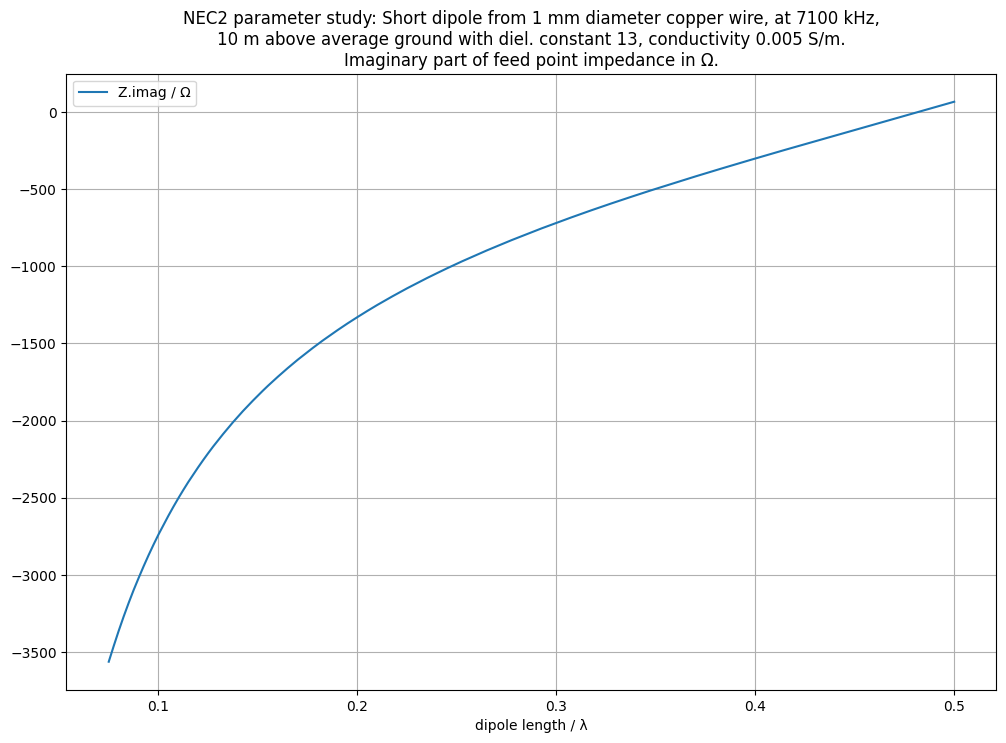

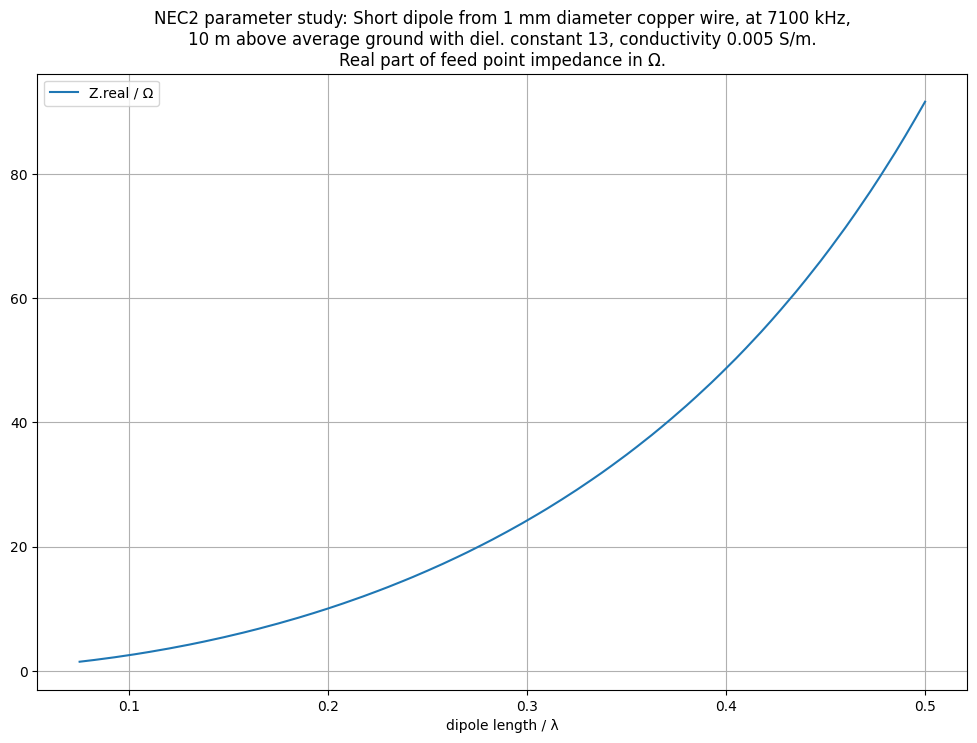

In [9]:
from math import sqrt
from antenna_simulation_driver import swr

def p(aip) -> float:
    """Power taken by the antenna at 1 V."""
    u = aip.voltage
    z = aip.impedance
    i = u / z
    p = abs(i)**2 * z.real
    return p

def l_q(z_ant, efficiency: float, z0: float = 50) -> float:
    """Required inductance quality factor for target efficiency.

    Assumes we are wanting a target efficiency,
    and we use a plain L-type antenna tuner to transform to z0.

    In our context, an L-type antenna tuner means:
    A lossy inductance in series with the antenna,
    an ideal capacitor parallel to that inductance+antenna block.
    """
    # Let's derive the formula for the r_loss we are willing to tolerate:
    # efficiency = z_ant.real / (z_ant.real + r_loss)
    # efficiency * (r_loss + z_ant.real) = z_ant.real
    # efficiency * r_loss + efficiency * z_ant.real = z_ant.real
    # efficiency * r_loss = (1 - efficiency) * z_ant.real
    # hence:
    r_loss = (1-efficiency) / efficiency * z_ant.real
    # This resistance needs to be transformed to z0:
    r_total = r_loss + z_ant.real
    # A L - type tuner with series-L first can only transform impedances that are smaller than z0:
    if z0 < r_total:
        return float("nan")
    # That transforming tuner needs an inductance of 1j * xl_transform:
    xl_transform = sqrt(r_total * (z0-r_total))
    # We also need to compensate the capacitance from the antenna:
    xl_needed = xl_transform - z_ant.imag
    if 0 <= xl_needed:
        return xl_needed / r_loss
    else:
        # Antenna is (too) inductive.
        # We don't deal with those in the context of the current study:
        return float("nan")

aips = [nr.input_and_impedance for nr in nec_results_copper_wire]

short_copper_dipoles = pd.DataFrame(
    {
        "Z": [aip.impedance for aip in aips],
        "Z.imag / Ω": [aip.impedance.imag for aip in aips],
        "Z.real / Ω": [aip.impedance.real for aip in aips],
        "Q": [abs(aip.impedance.imag) / abs(aip.impedance.real) for aip in aips],
        "SWR": [swr(aip.impedance) for aip in aips],
        # The power calculated by me, which I trust:
        "P from 1V feed": [p(aip) for aip in aips],
        # The power calculated by the simulation, which I do not understand / trust:
        "P from Simulation": [aip.power for aip in aips],
        "U/V for 5 W": [ sqrt(5 / p(aip)) for aip in aips ],
        "I/A for 5 W": [abs(sqrt(5 / p(aip)) / aip.impedance) for aip in aips],
        # I also calculated the Q of the antenna, but don't present those results,
        # as they can be confusing, and the insight these numbers provide is marginal:
        "Q_of_L for 1 dB": [l_q(api.impedance, one_db) for api in aips],
        "Q_of_L for 6 dB": [l_q(api.impedance, six_db) for api in aips],
    },
    index = ls_in_fraction_of_lambda
)
title_head = f"NEC2 parameter study: Short dipole from 1 mm diameter copper wire, at {f*1e-3:.0f} kHz,\n" \
    f"{height} m above average ground with diel. constant 13, conductivity 0.005 S/m.\n"
title_tail = ["Imaginary part of feed point impedance in Ω.", "Real part of feed point impedance in Ω."]

# axs = short_copper_dipoles[["Z.imag / Ω", "Z.real / Ω", "Q"]].plot.line(
axs = short_copper_dipoles[["Z.imag / Ω"]].plot.line(
    figsize=(12,8),
    grid=True,
    subplots=False,
    title=title_head + title_tail[0],
    xlabel="dipole length / λ",
)

short_copper_dipoles[["Z.real / Ω"]].plot.line(
    figsize=(12,8),
    grid=True,
    subplots=False,
    title=title_head + title_tail[1],
    xlabel="dipole length / λ",
)

plt.show()
pass

In [10]:
print(title_head)
print("Each dipole length is followed by two numbers:")
print(title_tail[1] + "\n" + title_tail[0])
print()

for i in [170, 150, 130, 110,90, 70, 50, 30, 10, 0]:
    r = short_copper_dipoles.iloc[i]
    print(
        f"{r.name:.3f} λ: "
        f"{r['Z.real / Ω'].real:5.1f} Ω, "
        f"{r['Z.imag / Ω'].real:7.1f} Ω."
        # f"{r['Q'].real:6.1f}"
    )

print(f"\nAn imaginary part of -3000 Ω at {f*1e-3:.0f} kHz corresponds to a C of {1e12/(ω*3000):.1f} pF.")

NEC2 parameter study: Short dipole from 1 mm diameter copper wire, at 7100 kHz,
10 m above average ground with diel. constant 13, conductivity 0.005 S/m.

Each dipole length is followed by two numbers:
Real part of feed point impedance in Ω.
Imaginary part of feed point impedance in Ω.

0.500 λ:  91.6 Ω,    66.6 Ω.
0.450 λ:  67.0 Ω,  -116.5 Ω.
0.400 λ:  48.7 Ω,  -301.5 Ω.
0.350 λ:  34.8 Ω,  -498.1 Ω.
0.300 λ:  24.2 Ω,  -718.7 Ω.
0.250 λ:  16.1 Ω,  -983.4 Ω.
0.200 λ:  10.1 Ω, -1329.6 Ω.
0.150 λ:   5.6 Ω, -1838.0 Ω.
0.100 λ:   2.5 Ω, -2739.0 Ω.
0.075 λ:   1.5 Ω, -3563.5 Ω.

An imaginary part of -3000 Ω at 7100 kHz corresponds to a C of 7.5 pF.


### Discussion of result

As the wire is not infinitely thin and also there's ground reasonably nearby, the resonance is slightly below
λ/2. Indeed, at exactly λ/2 dipole length the imaginary part of the impedance is positive, that is, inductive.

Straightforward theory predicts that halving the size of a short dipole
should divide the real part of the impedance by 4.
Even though the theory is valid for lossless dipoles only,
our data fits it reasonably well.

At the same time, capacitance decreases as dipoles get shorter.

### Are the impedances too high?

It may be somewhat surprising that the real part of the (nominal) half-wave
dipole comes out at 92 Ω. We expect a half-wave dipole's impedance to be 72 Ω,
decreasing with height. The 92 Ω mark seems a bit high.

To investigate this, we shorten the dipole until it becomes resonant
(at height 500 m above ground) and then vary its height.

In [11]:

def find_resonant_length() -> float:
    def length_to_imag(l: float) -> float:
        return run_nec2pp(generate_input(l=l, f=f, height=500)).input_and_impedance.impedance.imag
    solver_result = root_scalar(length_to_imag, x0=0.5*λ, bracket=(0.25*λ, 0.5*λ))
    if not solver_result.converged:
        raise RuntimeError("Ouch - that did not converge!")
    return solver_result.root    

resonant_length = find_resonant_length()
heights = [h for h in range(5,101)]
impedances = [
    (run_nec2pp(generate_input(
        l=resonant_length,
        f=f,
        ideal_wire=False,
        wire_radius=0.5e-3,
        height=height)).input_and_impedance.impedance)
    for height in heights
]

half_wave_dipole_by_height = pd.DataFrame(
    {
        "Z.real / Ω": [imp.real for imp in impedances],
        "Z.imag / Ω": [imp.imag for imp in impedances]
    },
    index=heights
)

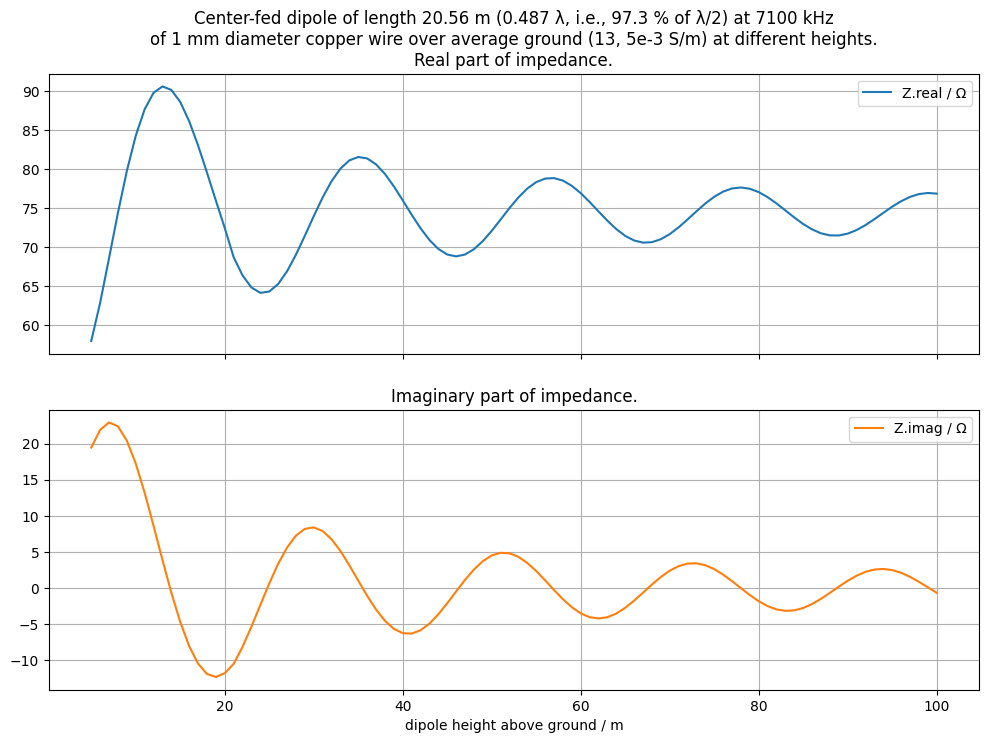

In [12]:
title_head = f"Center-fed dipole of length {resonant_length:.2f} m" \
    f" ({resonant_length/λ:.3f} λ, i.e., {100*resonant_length/(λ/2):.1f} % of λ/2)" \
    f" at {f*1e-3:.0f} kHz\n" \
    "of 1 mm diameter copper wire over average ground (13, 5e-3 S/m) at different heights.\n"

subtitle = ("Real part of impedance.", "Imaginary part of impedance.")

half_wave_dipole_by_height[["Z.real / Ω", "Z.imag / Ω"]].plot.line(
    figsize=(12,8),
    grid=True,
    subplots=True,
    title=[title_head + subtitle[0], subtitle[1]],
    xlabel="dipole height above ground / m",
)
pass

In [13]:
print(title_head)
print("In each line, the height above ground is followed by the two numbers:\n"
      + subtitle[0] + "\n" + subtitle[1] + "\n")

for i in range(0,len(half_wave_dipole_by_height)):
    row = half_wave_dipole_by_height.iloc[i]
    print(f"{row.name:3d} m: {row['Z.real / Ω']:4.1f} Ω, {row['Z.imag / Ω']:5.1f} Ω")

Center-fed dipole of length 20.56 m (0.487 λ, i.e., 97.3 % of λ/2) at 7100 kHz
of 1 mm diameter copper wire over average ground (13, 5e-3 S/m) at different heights.

In each line, the height above ground is followed by the two numbers:
Real part of impedance.
Imaginary part of impedance.

  5 m: 58.0 Ω,  19.4 Ω
  6 m: 62.9 Ω,  21.9 Ω
  7 m: 68.6 Ω,  22.9 Ω
  8 m: 74.4 Ω,  22.4 Ω
  9 m: 79.8 Ω,  20.4 Ω
 10 m: 84.3 Ω,  17.2 Ω
 11 m: 87.7 Ω,  13.2 Ω
 12 m: 89.8 Ω,   8.6 Ω
 13 m: 90.6 Ω,   3.9 Ω
 14 m: 90.2 Ω,  -0.6 Ω
 15 m: 88.6 Ω,  -4.7 Ω
 16 m: 86.2 Ω,  -8.0 Ω
 17 m: 83.1 Ω, -10.4 Ω
 18 m: 79.6 Ω, -11.9 Ω
 19 m: 76.0 Ω, -12.3 Ω
 20 m: 72.5 Ω, -11.8 Ω
 21 m: 68.7 Ω, -10.5 Ω
 22 m: 66.4 Ω,  -8.1 Ω
 23 m: 64.8 Ω,  -5.3 Ω
 24 m: 64.2 Ω,  -2.3 Ω
 25 m: 64.3 Ω,   0.6 Ω
 26 m: 65.3 Ω,   3.4 Ω
 27 m: 66.9 Ω,   5.6 Ω
 28 m: 69.0 Ω,   7.3 Ω
 29 m: 71.5 Ω,   8.2 Ω
 30 m: 74.0 Ω,   8.4 Ω
 31 m: 76.4 Ω,   7.9 Ω
 32 m: 78.5 Ω,   6.8 Ω
 33 m: 80.1 Ω,   5.1 Ω
 34 m: 81.1 Ω,   3.2 Ω
 35 m: 81.6 Ω,   1.0

## How to feed such an animal? - Requirements

The imaginary part of the impedance acts like a capacitor and hence does not consume power,
but only stores energy. It is the real part of the impedance that consumes power.

To deliver the same power to a resistance that decreases as
the dipole gets smaller, the current must increase correspondingly; the formula governing this is good old `P = I² R`.

But to feed the antenna, we have to squeeze this
current through the increasing imaginary part of the impedance,
in other words, through a capacitor with a value that decreases and decreases.
For accomplish this, we shall need more and more voltage.

Let us investigate the current and voltage needed to deliver 5 W of power
into the impedance presented by the short dipole, as a function of dipole length.

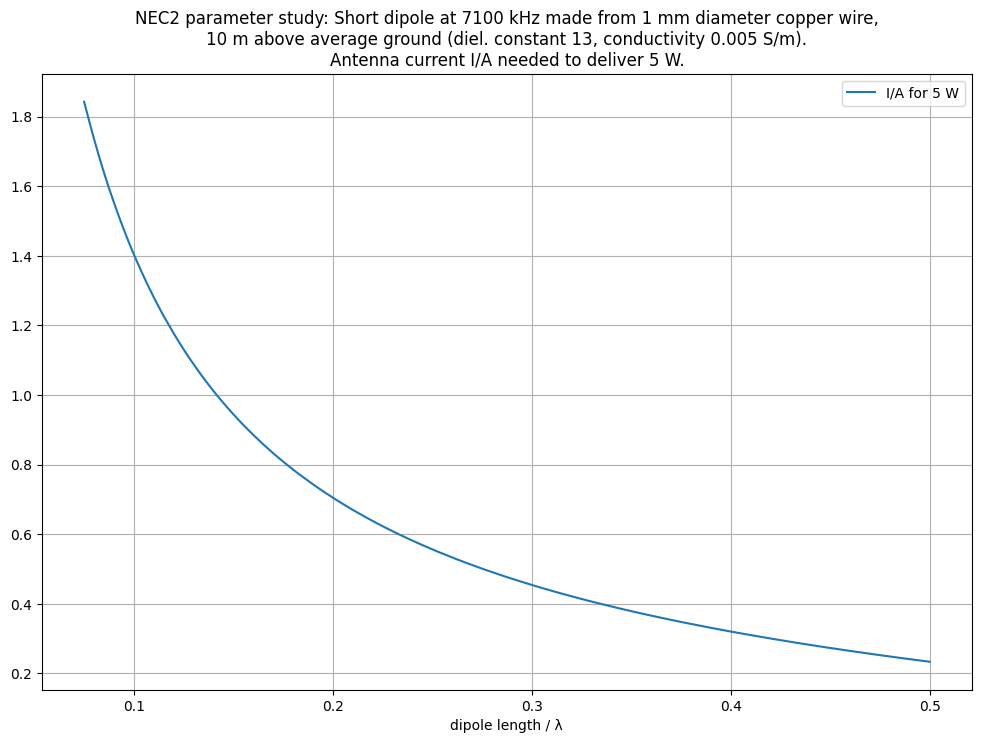

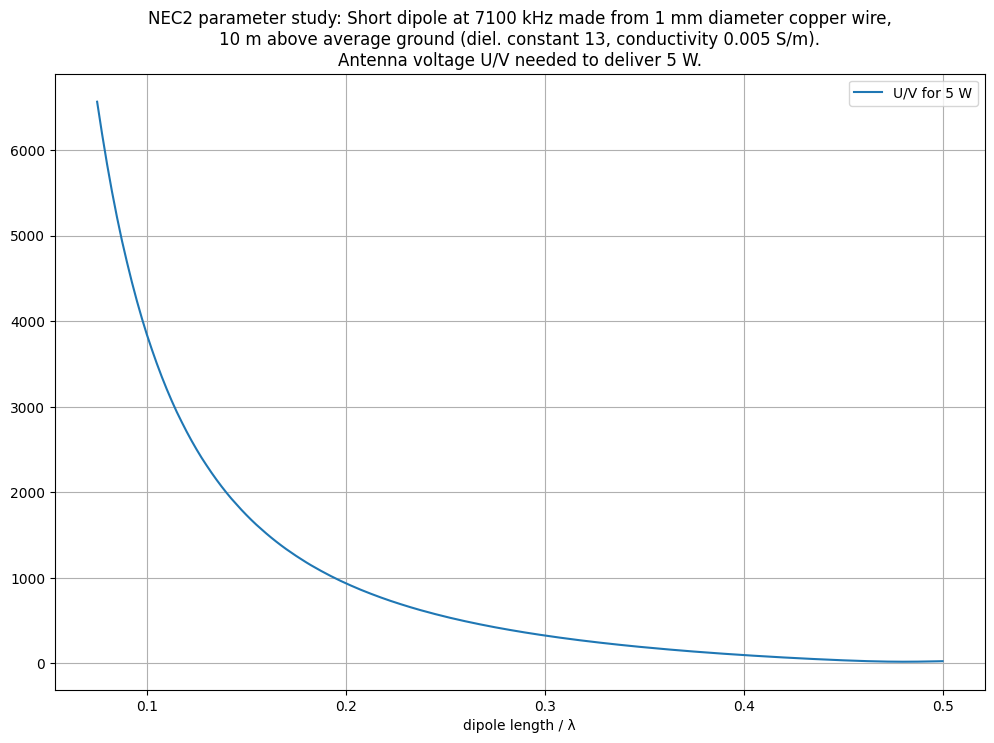

In [14]:
title_head = f"NEC2 parameter study: Short dipole at {1e-3*f:.0f} kHz" \
    " made from 1 mm diameter copper wire,\n"\
    f"{height} m above average ground (diel. constant 13, conductivity 0.005 S/m).\n"

title_tail = [
        "Antenna current I/A needed to deliver 5 W.",
        "Antenna voltage U/V needed to deliver 5 W."
]

axs = short_copper_dipoles[["I/A for 5 W", ]].plot.line(
    figsize=(12,8),
    grid=True,
    subplots=False,
    title=title_head + title_tail[0],
    xlabel="dipole length / λ",
)
short_copper_dipoles[["U/V for 5 W", ]].plot.line(
    figsize=(12,8),
    grid=True,
    subplots=False,
    title=title_head + title_tail[1],
    xlabel="dipole length / λ",
)
plt.show()
pass

In [15]:
print(title_head)
print("\nEach dipole length is followed by two numbers:")
print(title_tail[0])
print(title_tail[1])
print()

for i in [170, 150, 130, 110,90, 70, 50, 30, 10, 0]:
    r = short_copper_dipoles.iloc[i]
    print(
        f"{r.name:.3f} λ: "
        f"{r['I/A for 5 W'].real:4.2f} A "
        f"{r['U/V for 5 W'].real:7.1f} V"
    )

NEC2 parameter study: Short dipole at 7100 kHz made from 1 mm diameter copper wire,
10 m above average ground (diel. constant 13, conductivity 0.005 S/m).


Each dipole length is followed by two numbers:
Antenna current I/A needed to deliver 5 W.
Antenna voltage U/V needed to deliver 5 W.

0.500 λ: 0.23 A    26.5 V
0.450 λ: 0.27 A    36.7 V
0.400 λ: 0.32 A    97.8 V
0.350 λ: 0.38 A   189.2 V
0.300 λ: 0.45 A   326.7 V
0.250 λ: 0.56 A   547.3 V
0.200 λ: 0.71 A   937.6 V
0.150 λ: 0.94 A  1736.5 V
0.100 λ: 1.40 A  3845.3 V
0.075 λ: 1.84 A  6566.7 V


### Discussion of result

The current rises moderately; shrinking dipole length from λ/2 to λ/10 raises current from 0.23 to 1.27 A. Very roughly: The length has dropped to 1/5 of the original, so about 5 times the current is needed to achieve the desired radiation.

At the same time, the required voltage pretty much explodes, from 26.5 to 3845 V.

Fortunately, for the shorter dipoles, I and U are almost precisely 90° out of phase.
So both can be supplied with an inductivity to form a resonant circuit.
The other half of the resonant circuit is the capacitor that represents the antenna.
To the extend the antenna radiates, that capacitor is lossy. So loss is good.

If the antenna is short, this resonant circuit will store a lot of energy
and radiate only comparatively little power.

### Antenna Q value

This can be captured quantitatively by the antenna's Q value.

We have augmented the antenna with an external inductor to form
a resonant circuit. The antenna's Q is the quotion of the energy stored in the
resonant circuit divided by the amount of energy that gets consumed by the antenna
during one period of the HF signal.

So, as a sideline, let us investigate antenna Q before continuing with
the discussion of the result. As the values explode to above 2000 for
very short dipoles, we restrict this investigation to dipoles at least 0.15 λ long.

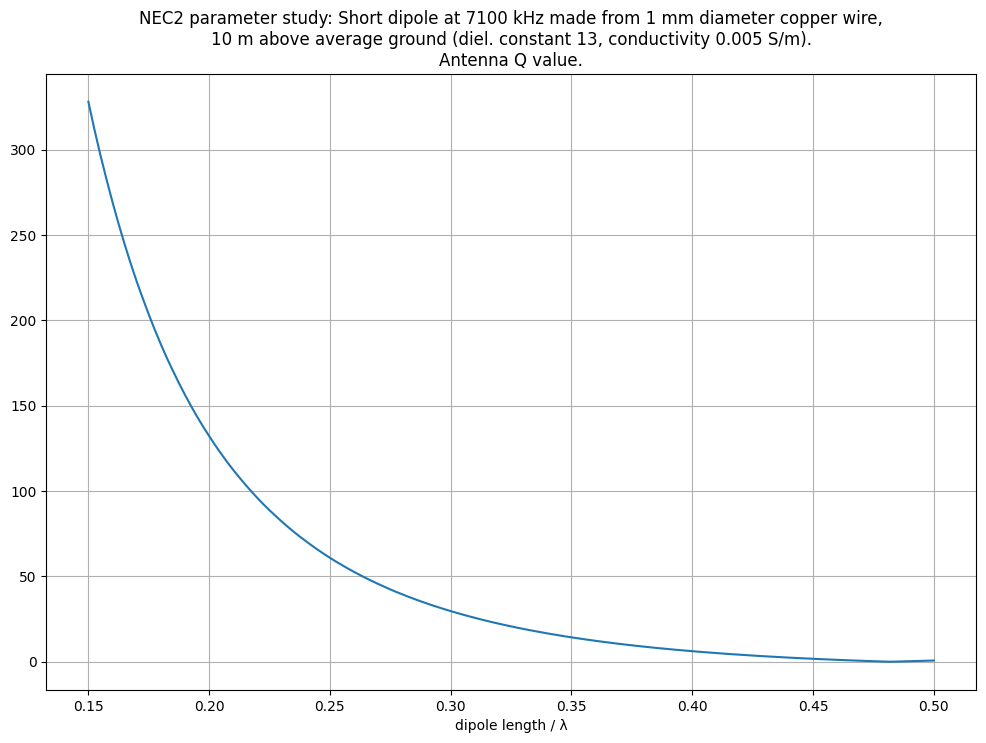

In [16]:
short_copper_dipoles_reasonably_long = \
    short_copper_dipoles.iloc[[
        i for i in range(len(ls_in_fraction_of_lambda)) if 0.15 <= ls_in_fraction_of_lambda[i]
    ]]

short_copper_dipoles_reasonably_long["Q"].plot.line(
    figsize=(12,8),
    grid=True,
    subplots=False,
    title=title_head + "Antenna Q value.",
    xlabel="dipole length / λ",
)
pass

In [17]:
print(title_head)
print("\nEach dipole length is followed by the antenna's Q value.\n")

for i in range(len(short_copper_dipoles_reasonably_long)-1, -1, -10):
    r = short_copper_dipoles_reasonably_long.iloc[i]
    print(
        f"{r.name:.3f} λ: "
        f"{r['Q'].real:4.1f}"
    )

NEC2 parameter study: Short dipole at 7100 kHz made from 1 mm diameter copper wire,
10 m above average ground (diel. constant 13, conductivity 0.005 S/m).


Each dipole length is followed by the antenna's Q value.

0.500 λ:  0.7
0.475 λ:  0.3
0.450 λ:  1.7
0.425 λ:  3.6
0.400 λ:  6.2
0.375 λ:  9.6
0.350 λ: 14.3
0.325 λ: 20.7
0.300 λ: 29.7
0.275 λ: 42.4
0.250 λ: 60.9
0.225 λ: 88.7
0.200 λ: 132.2
0.175 λ: 203.5
0.150 λ: 328.1


### Continuation of discussion of result

As is typical for resonant circuits, energy is constantly shifts between L and C.
Twice per signal period, all energy is stored in the C, that is, in the antenna, none in the L.
Where and how does the energy actually get stored?

The energy is stored in the near field of the antenna.

A quarter period later, all that energy is stored in the L and none in the antenna.

So, over time, a lot of energy is fed into the near field and extracted from the near field over and over again.

The shorter the antenna, the more such energy.

One consequence of this is: **Short dipoles produce strong near fields,**
even at relatively moderate transmit powers.

We will see that losses rise as dipoles are shortened.
It is tempting to compensate by increasing raw transmitter power.
Doing so will also further increase the near field.

Short antennas require higher safety distances to limit field exposure.

But then, the hwg concept recommends to make creative use of the space available!

This will typically lead to short distance between the antenna and places
that can have humans in them. This is an inherent conflict.

(Incidentally, the same conflict also comes up with other small antennas,
such as small verticals and magnetic loops, for the same reason: High Q
and large near field. It can be both instructive and sobering
to check how the manufacturers of such antennas treat this topic in their material.)

I recommend thinking twice, and carefully so, before pushing more than, say,
5 W into an hgw antenna.

### A personal tale

German hams are required to hand in paperwork if transmitting with more than 10 W EIRP
([§ 9 BEMFV](https://www.gesetze-im-internet.de/bemfv/__9.html)) from a permanent location.
Once a German ham does the paperwork for some antennas,
the use of other antennas at the same location that are not documented in said paperwork
is not permitted without augmenting the paperwork first.

I live in a rented flat in the city of Berlin, Germany. I erect my dipole antennas
before transmitting and pull them back in afterwards. They occasionally change as I experiment.
One dipole wire usually runs directly alongside the house, in best hwg fashion.

All of this makes doing the paperwork hard, if not infeasible, for me.
So I decided to stay below 10 W EIRP and leave it at that.

This makes me the proverbial "little pistol" station and limits what I can do.
Still, even a compromise inner-city station like mine can
produce a [lot of fun](https://mastodon.radio/@dj3ei/112812449458035994).

## How to feed such an animal? - The L tuner

Once the real part of the impedance to be tuned has become lower than 50 Ω,
one variant of the L - tuner can be used
to present a 50 Ω load to a transceiver that wants to see such a load.

Such a tuner consists of an inductance L in series with the antenna,
and then a capacitance in parallel (with the combination of L and the antenna).

The trick is to choose L in a particular fashion.
If done right, that L and the antenna together have an
impedance that can be represented as 50 Ω _in parallel_ with some other inductance L₁.

That new impedance L₁ is then resonated with the L - tuner's C. The 50 Ω remains.

Advertisement block: I gave a talk on the details at Ham Radio Friedrichshafen in 2022.
The slides are in German.
They are intended to be readable without listening to me doing talking, and can be found at
[https://dj3ei.famsik.de/2022-vortrag-hamradio/](https://dj3ei.famsik.de/2022-vortrag-hamradio/).

### Some facts about antennas and tuners

A lot of lore and "alternative facts" cloud what should really be solid physics and science.

To shed a bit of light and discuss what is going on,
let us consider the case of our 0.2 λ dipole with Q of 127 and impedance
(all complex and real impedances in this section in Ω) 11 - 1395j.

Like a rabbit out of a cylinder, I pull out the L needed to tune: It is 1415.7j.
Antenna and L in series result in an impedance of 11+20.7j,
which is the same as resistor of 50 in parallel with an inductivity of 26.55j.
The latter is canceled out by the L-tuner's parallel capacitor of -26.55j.
The 50 Ω resistor remains - just what we want.

To deliver 5 W of power, the transceiver produces 15.8 V of HF.
That voltage produces a current of 595j mA through the capacitor
and (316-595j) mA through coil and antenna.
Those two currents neatly add up to the 316 mA the transceiver yields to produce the 5 W.

The amplitude abs(316-595j) of the current through the antenna is 674 mA, which fits the 0.67 A given by the table above.

The voltage across the antenna comes out to (-826.5-447.4j) V,
the amplitude of which is 939.8 V, which again fits the
above table (up to rounding errors, as the calculations here have been done with rounded values).

The antenna appears as an impedance of 11.0-1395.0j.
The current of 674 mA through that causes 7.41 V to appear across the 11.0 Ω
resistor. This resistor consumes a power of 674 mA * 7.41 V = 5 W.

The -1395.0j capacitor of the antenna stores energy in the antenna's near field
and sends it back to the tuner's L in resonant circuit fashion.

This repeats what we have seen before:
There is a decent amount of energy stored in the antenna's **near field**.

Energy just goes back and forth between L and antenna.
That energy remains at a constant level over time, as the transceiver
steadily delivers 5 W into the tuner,
and the antenna steadily consumes 5 W.  Equilibrium is maintained.

When the transceiver first starts to transmit,
it takes a few microseconds for steady state to be reached.
As a ballpark figure, maybe 20 cycles of a 7 MHz signal are required.
That would need a little less than 3 µs.

So this happens very quickly, compared to the slow build-up of transceiver output power.
5 ms power build-up are recommended for high-speed telegraphy.
That's more than 1000 times longer. Hence, reaching steady state is not a problem.
Whether a real 50 Ω resistor is connected or an antenna tuner with an antenna -
the transmitter will not notice any difference.

To summarize:

- The transmitter hands out 15.8 V at 316 mA resulting in 5 W.
- The transceiver is operating into a resistive load, the SWR is 1, and the transceiver is happy.
- We have modeled the L tuner as lossless, with an ideal L and an ideal C. Ideal L and C do not
  consume power (once steady state has been reached),
  they just store and deliver it in an endless circle.
- The antenna consumes precisely the 5 W delivered by the transmitter.
- The transceiver operates at its specified power,
  of which all goes to the antenna, and nothing is lost in the tuner.
- The transceiver operates at the 50 Ω load it is designed for.

This is if the tuner itself is lossless. We will investigate tuner losses shortly.
As long as we can ignore tuner (and cable) losses, the picture now becomes:

- The transceiver delivers 5 W into the tuner,
- the tuner delivers 5 W into, say, a short piece of cable,
- the cable delivers 5 W into the antenna,
- the antenna consumes those 5 W.

## SWR on a 50 Ω base?

If one views the situation through 50 Ω glasses: The reflection coefficient at the antenna
comes out as 0.99687-0.07155j with |r| = 0.999436, and the SWR a whooping 3543.

I consider this information largely meaningless. It might be useful if
a non-trivial length of cable is introduced here, and the situation
_on that cable_ is to be analyzed. As long as were are interested in the
interplay between tuner and antenna, SWR on a cable is irrelevant.

### Sideline: Coax losses.

In the previous discussion, we saw an extraordinary high SWR value of 3543,
from the point of view of a 50 Ω system impedance.

This warns that regular 50 Ω coax cable might result in surprisingly high losses
if any appreciable length of it is used.

People using short antennas
often use two-wire cable if antenna and tuner need to be separated, rather than 50 Ω coax.

There are good reasons for that. One reason:
Two-wire "chicken ladder" or "window" feedline offers lower loss than does coax.

In our hwg case, it often happens that a cable is short.
Maybe just a meter or two are needed from the operating desk to the window sill.
In this case, loss may remain reasonable in spite of extreme SWR, due to short cable length.

That's it, folks, as far as cable loss is concerned.
Beyond the quite general remarks given,
it will not be discussed any further in this current document.

Any cable transforms impedance. This sometimes hurts and can often be used to advantage.

Two-wire feedline sometimes transforms impedances of short antennas into values that
are more manageable for typical antenna tuners,
compared to what an equal length of coax would do. This can be a second reason
for using two-wire line as opposed to coax.

Details are also not discussed here.
But, for what it's worth, another advertisement:
I have given a talk on the transformation properties of (lossless) feedline.
The talk was originally presented during Ham Radio Friedrichshafen 2023, a second
installment with improvements followed online later that same year. The slides are in German. 
They are intended to be comprehensible without me talking, and can be found at
[https://dj3ei.famsik.de/2023-Vortrag_HF-Leitungen/](https://dj3ei.famsik.de/2023-Vortrag_HF-Leitungen/).

## Antenna losses

Let us now investigate antenna loss in more detail.

Two relevant points from the previous discussion are:

- When dipoles get shorter, the current needs to increase for the same power
  to be transmitted. So we can expect increased wire losses.
- When dipoles get shorter, the near field gets stronger.
  So we can expect increased ground losses.

This is investigated in some detail as follows:

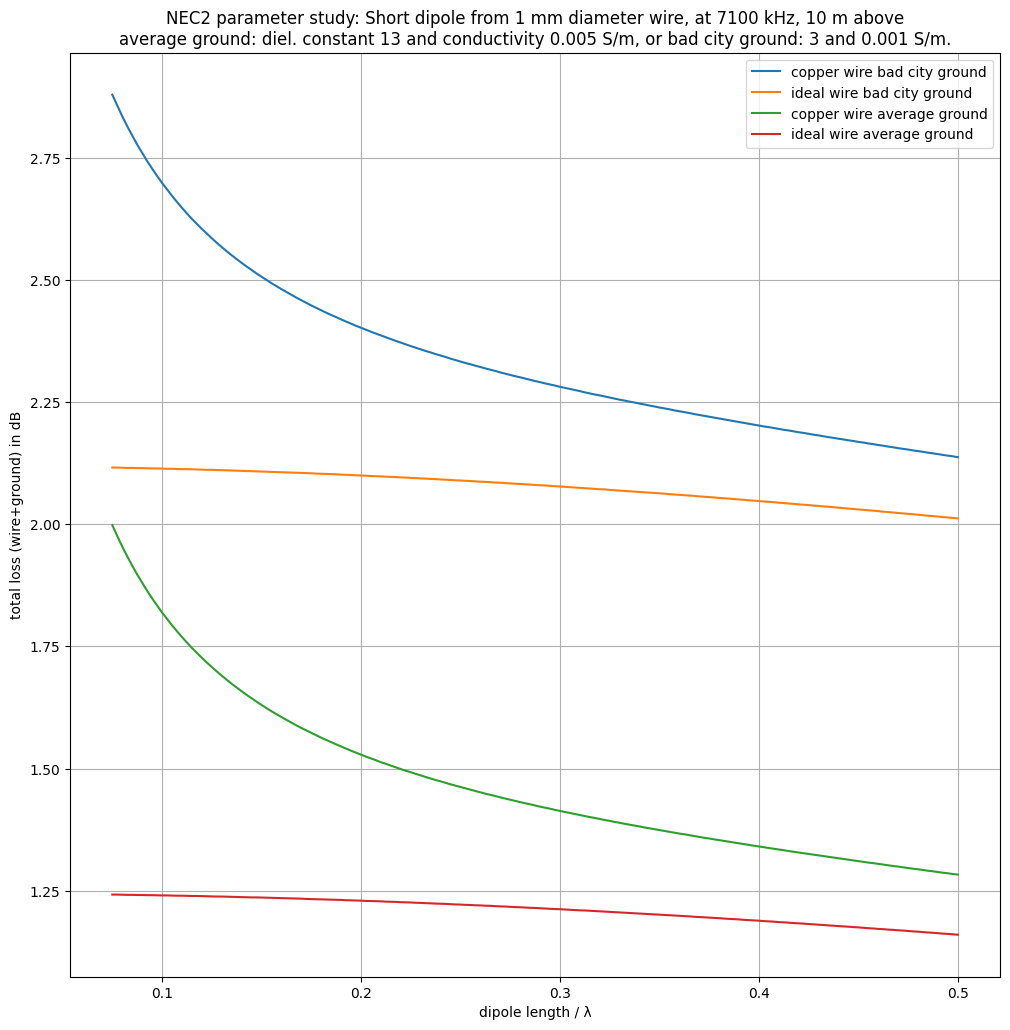

In [18]:
total_loss_per_dipole_length = pd.DataFrame(
    {
        "copper wire bad city ground": [dBloss_from_efficiency(nr.total_efficiency.efficiency) for nr in nec_results_copper_wire_city_ground],
        "ideal wire bad city ground":[dBloss_from_efficiency(nr.total_efficiency.efficiency) for nr in nec_results_ideal_wire_city_ground],
        "copper wire average ground": [dBloss_from_efficiency(nr.total_efficiency.efficiency) for nr in nec_results_copper_wire],
        "ideal wire average ground": [dBloss_from_efficiency(nr.total_efficiency.efficiency) for nr in nec_results_ideal_wire],
    },
    index = ls_in_fraction_of_lambda
)
title=f"NEC2 parameter study: Short dipole from 1 mm diameter wire, at {f*1e-3:.0f} kHz, " \
        f"{height} m above\naverage ground: diel. constant 13 and conductivity 0.005 S/m, or bad city ground: 3 and 0.001 S/m."
axs = total_loss_per_dipole_length.plot.line(
    figsize=(12,12),
    grid=True,
    subplots=False,
    xlabel="dipole length / λ",
    ylabel="total loss (wire+ground) in dB",
    title=title
)


plt.show()

In [19]:
# For accessability:

print(title)
print("Total loss (wire and ground) as a function of dipole length.\n")
print("Each dipole length is followed by four loss numbers:")
for row in total_loss_per_dipole_length:
    print(row)
print()
for i in range(170, -1, -20):
    r = total_loss_per_dipole_length.iloc[i]
    print(
        f"{r.name:.3f} λ: "
        f"{r['copper wire bad city ground']:.2f} dB, "
        f"{r['ideal wire bad city ground']:.2f} dB, "
        f"{r['copper wire average ground']:.2f} dB, "
        f"{r['ideal wire average ground']:.2f} dB"
    )

NEC2 parameter study: Short dipole from 1 mm diameter wire, at 7100 kHz, 10 m above
average ground: diel. constant 13 and conductivity 0.005 S/m, or bad city ground: 3 and 0.001 S/m.
Total loss (wire and ground) as a function of dipole length.

Each dipole length is followed by four loss numbers:
copper wire bad city ground
ideal wire bad city ground
copper wire average ground
ideal wire average ground

0.500 λ: 2.14 dB, 2.01 dB, 1.28 dB, 1.16 dB
0.450 λ: 2.17 dB, 2.03 dB, 1.31 dB, 1.18 dB
0.400 λ: 2.20 dB, 2.05 dB, 1.34 dB, 1.19 dB
0.350 λ: 2.24 dB, 2.06 dB, 1.37 dB, 1.20 dB
0.300 λ: 2.28 dB, 2.08 dB, 1.41 dB, 1.21 dB
0.250 λ: 2.33 dB, 2.09 dB, 1.46 dB, 1.22 dB
0.200 λ: 2.40 dB, 2.10 dB, 1.53 dB, 1.23 dB
0.150 λ: 2.51 dB, 2.11 dB, 1.63 dB, 1.24 dB
0.100 λ: 2.70 dB, 2.11 dB, 1.82 dB, 1.24 dB


In [20]:
# To enable garbage collection:

nec_results_ideal_wire = None
nec_results_ideal_wire_city_ground = None
nec_results_copper_wire = None
nec_results_copper_wire_city_ground = None

### Discussion

At one mm copper wire diameter, wire loss is present, but it is clearly dominated by ground loss.
This is especially true for people that have to put up with bad city ground,
like (I'm afraid) myself: Even with ideal wire, ground loss remains 2.01 dB for a half-wave dipole.

Shortening the antenna increases wire loss, but only by less than one additional dB,
even for very short antennas with real wire over bad ground.

In [21]:
# How long is a 0.3 λ antenna at our chosen design frequency?
f"l = 2 x {0.15 * λ:.2f} m = {0.3 * λ:.2f}"

'l = 2 x 6.34 m = 12.68'

In [22]:
wires = ["ideal", "copper"]
grounds = GROUNDS.keys()

wgs = [(w, g) for w in wires for g in grounds ]
ground_study_sim_results = [run_nec2pp(generate_input(l=0.3*λ, f=f, ideal_wire=(wg[0] == "ideal"), ground_type=wg[1])) for wg in wgs]
ground_study = pd.DataFrame(
    {
        "ground dielectric constant": [GROUNDS[wg[1]][0] for wg in wgs], 
        "ground conductivity in S/m": [GROUNDS[wg[1]][1] for wg in wgs], 
        "impedance": [complex(round(gssr.input_and_impedance.impedance.real,1), round(gssr.input_and_impedance.impedance.imag,1))
                          for gssr in ground_study_sim_results],
        "efficiency in %": [round(gssr.total_efficiency.efficiency * 100,1) for gssr in ground_study_sim_results],
        "loss in dB": [round(dBloss_from_efficiency(gssr.total_efficiency.efficiency),2) for gssr in ground_study_sim_results]
    },
    index = pd.MultiIndex.from_tuples(wgs, names=["wire", "ground"])
)
ground_study

ground dielectric constant  ground conductivity in S/m  \
wire   ground                                                               
ideal  ideal                              NaN                         NaN   
       salt water                        81.0                       5.000   
       excellent                         20.0                       0.030   
       average                           13.0                       0.005   
       industry                           5.0                       0.001   
       city                               3.0                       0.001   
copper ideal                              NaN                         NaN   
       salt water                        81.0                       5.000   
       excellent                         20.0                       0.030   
       average                           13.0                       0.005   
       industry                           5.0                       0.001   
       city                               3.0                       0.001   

                     impedance  efficiency in %  loss in dB  
wire   ground                                                
ideal  ideal       22.7-715.6j            100.0        0.00  
       salt water  22.8-715.7j             99.0        0.05  
       excellent   23.5-717.7j             87.9        0.56  
       average     23.1-719.8j             75.6        1.21  
       industry    22.4-722.0j             63.1        2.00  
       city        22.8-722.8j             62.0        2.08  
copper ideal       23.8-714.5j             95.4        0.21  
       salt water  23.9-714.7j             94.4        0.25  
       excellent   24.6-716.6j             84.0        0.76  
       average     24.2-718.7j             72.2        1.41  
       industry    23.5-720.9j             60.2        2.21  
       city        23.9-721.8j             59.1        2.28

### Discussion of result

Whether ideal or copper wire is used apparently makes little difference, only 0.2 dB or 0.955%.

The feedpoint impedance of this antenna remains largely unaffected by ground conditions.

But ground conditions have an effect on overall antenna efficiency.
Compared with a salt water environment, the inner city dweller can
expect an additional loss of up to 2 dB.

The summary reiterates what we have seen above:
Ground loss seems to be the major contributor, not wire loss.
(We'll see that yet one more time in a different exploration below.)

(Out of scope here: This discussion says nothing about how ground influences the radiation pattern.)

In [23]:
# To enable garbage collection

ground_study_sim_results = None

## Tuner losses

Some amateurs view tuners with deep suspicion. Are they not lossy?

This is not entirely unfounded. Some of the more versatile tuners allow transformation of their own losses to the 50 Ω
the transmitter wants to see, _with no antenna attached._ In that extreme case, tuner loss is 100 %.

We will investigate the "L in series, C in parallel" tuner, also known as "L-tuner".
It is easy to analyze and well behaved in this respect. It tends to have low losses.
It is also typical for some of the automatic tuners that are quite popular these days.

One can generally pretend that all tuner losses stem from the coils.
Decent capacitors have much higher Q, the voltage across them in our application is low,
so they can be treated as lossless: The error will be negligible.

Clearly, as the dipole gets shorter, the tuner needs to do more transformation work.
In the following study, we assume that 1 dB of loss or 79 % tuner efficiency
are deemed acceptable. To achieve that, a better and better
coil needs to be used (higher Q) the shorter the dipole gets.
So the question is: What coil Q do we need to keep
tuner losses at 1 dB, for a given dipole length?

### Realistic Q values, anyone?

I have not myself yet done experiments with winding coils and measuring their Q.
Such experiments have been in my pipeline
for a long time, but I have not actually done them.

But here is my general impression from what I've read over the years:

- Q of 100 is easy,
- to proceed to the 200-300 range requires a certain amount of care,
- whereas serious efforts can result in (big monster) coils with a Q of 1000.

All of these in the short-wave range, high Q is easier for VHF.
This data should be treated with some caution,
it is more the result of hearsay than experimentation.

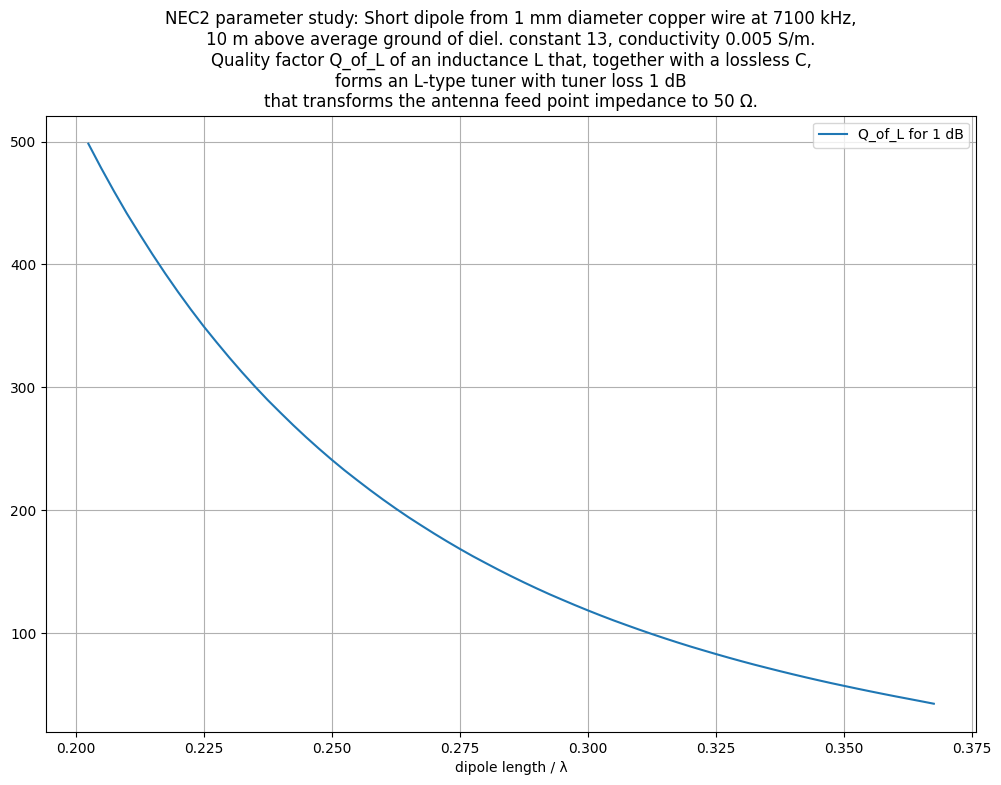

In [24]:
interesting_dipoles = short_copper_dipoles["Q_of_L for 1 dB"] < 500

title_head= "NEC2 parameter study: Short dipole from 1 mm diameter copper wire " \
    f"at {f*1e-3:.0f} kHz,\n" \
    f"{height} m above average ground of diel. constant 13, conductivity 0.005 S/m.\n"

title_tail = "Quality factor Q_of_L of an inductance L that, together with a lossless C,\n" \
    "forms an L-type tuner with tuner loss 1 dB\n" \
    "that transforms the antenna feed point impedance to 50 Ω."


axs = short_copper_dipoles[interesting_dipoles][["Q_of_L for 1 dB"]].plot.line(
    figsize=(12,8),
    grid=True,
    title=title_head + title_tail,
    xlabel="dipole length / λ",
)
plt.show()

In [25]:
from math import isnan

print(title_head)
print("\nEach dipole length is followed by:")
print(title_tail)

print()
for i in range(0, len(short_copper_dipoles)+1, 10):
    r = short_copper_dipoles.iloc[i]
    ql = float(r['Q_of_L for 1 dB'].real)
    if not isnan(ql) and ql < 500:
        print(
            f"{r.name:.3f} λ: "
            # f"{r['Q'].real:.2f}, "
            f"{ql:.2f}"
        )

NEC2 parameter study: Short dipole from 1 mm diameter copper wire at 7100 kHz,
10 m above average ground of diel. constant 13, conductivity 0.005 S/m.


Each dipole length is followed by:
Quality factor Q_of_L of an inductance L that, together with a lossless C,
forms an L-type tuner with tuner loss 1 dB
that transforms the antenna feed point impedance to 50 Ω.

0.225 λ: 349.69
0.250 λ: 241.11
0.275 λ: 168.56
0.300 λ: 118.48
0.325 λ: 82.96
0.350 λ: 57.08


### Discussion of result

For 1 dB loss in this type of tuner, about a quarter-wavelength dipole seems to be the limit for realistic inductor Q, so 2 x λ/8.

This maps well to a rule of thumb I have promoted for a long time:

> Divide the length of a full-size half-wave dipole by 2, and you end up with
> a short dipole that is still operable via tuner with acceptable losses.

### Side remark: Dipole needs to be short enough for the loss to be possible

As an interesting side remark, for dipoles longer than 0.367 λ, no solution is found.  How come?

Let us see what happens when the antenna is 0.4 λ long. From the material above, we find it
presents a load of 48.7-j301.5 Ω to the tuner.

For our purpose, only the real part of 48.7 Ω is relevant. To increase the loss above 1 dB,
an additional series loss resistance of 12.6 Ω is needed, which the coil would need
to introduce to produce that loss.
But 12.6 Ω raise the real value of the impedance to 48.7 + 12.6 = 61.3 Ω, a value well above 50 Ω.

Now the type of tuner we use can only transform an impedance with real part _below_ 50 Ω.
With that type tuner, 50 Ω impedance at the tranceiver cannot be reached at 1 dB loss.

So if you can tune this 0.4 λ dipole with an L-type
tuner to SWR 1, tuner loss is guaranteed to be below 1 dB.

In [26]:
# Calculating the additional and the total resistance needed for 1 dB loss,
# when the base resistance is 48.7 Ω.
48.7 / 10**-0.1 - 48.7, 48.7 / 10**-0.1

(12.609667554375946, 61.30966755437595)

### (No-)Desperation antennas

"This is all very nice," some may say, "but I have got no place for a 2 x λ/8 dipole.
I would accept even much higher losses if I can have any antenna whatsoever."

Very well. Been there, done that. I took part in the 2018 IARU HF Championship contest
with a 5 W "blue cool radio" CW QRP rig
and an improvised (short) off-center-fed vertical dipole. At the time, an antenna simulation
predicted ground+wire loss of 75 %, or 6 dB. I never bothered to estimate tuner losses.
It was a shitty setup, but in my opinion, it would have been much worse to not be able
to join the 80 m fun at all. I enjoyed, among others, 24 QSOs with WRTC Y8-stations,
16 of those on 80 m.

More generally speaking, I also tend to enjoy a small handful of 160 m CW QSOs
each year in the wee hours of the night during IARU HF Championship,
with an antenna that's a bit on the short side even for 80 m.
It does help to have an attentive station with good listening skills
as the QSO partner. DA0HQ in particular can hear the grass cough and the fleas grow.

What is the upper limit of losses beyond which no fun can be had? I truly don't know the answer.
It may not exist. From my own experience, yes, with a high-loss setup, you do not actually
reach all stations you would like to reach. On the other hand, one again and again finds
reports of happy users of obviously mediocre antennas (in particular, short verticals).

So, for the sake of an example, the following study assumes 6 dB tuner loss is acceptable.
Cutting off investigation when of (somewhat unrealistic) Q of more than 500 is needed,
let us investigate how short dipoles may get.

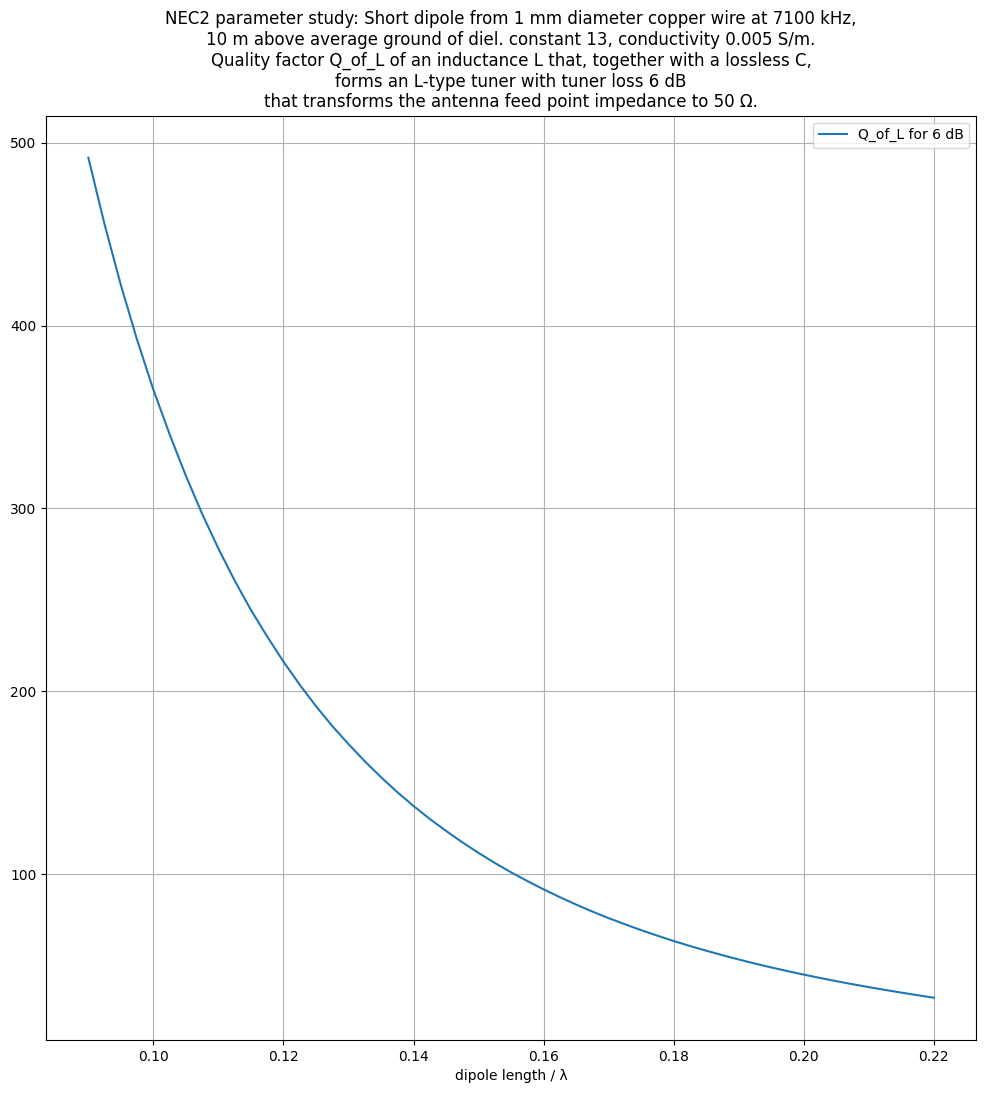

In [27]:
interesting_dipoles = short_copper_dipoles["Q_of_L for 6 dB"] < 500
title_head = f"NEC2 parameter study: Short dipole from 1 mm diameter copper wire at {f*1e-3:.0f} kHz,\n" \
    f"{height} m above average ground of diel. constant 13, conductivity 0.005 S/m.\n"
title_tail =  "Quality factor Q_of_L of an inductance L that, together with a lossless C,\n" \
    "forms an L-type tuner with tuner loss 6 dB\n" \
    "that transforms the antenna feed point impedance to 50 Ω."

axs = short_copper_dipoles[interesting_dipoles][["Q_of_L for 6 dB"]].plot.line(
    figsize=(12,12),
    grid=True,
    subplots=False,
    title=title_head + title_tail,
    xlabel="dipole length / λ",
)
plt.show()

In [28]:
print(title_head)
print("\nEach dipole length is followed by:")
print(title_tail)

print()
for i in range(0, len(short_copper_dipoles)+1, 5):
    r = short_copper_dipoles.iloc[i]
    ql = float(r['Q_of_L for 6 dB'].real)
    if not isnan(ql) and ql < 500:
        print(
            f"{r.name:.3f} λ: "
            f"{ql:.2f}"
        )

NEC2 parameter study: Short dipole from 1 mm diameter copper wire at 7100 kHz,
10 m above average ground of diel. constant 13, conductivity 0.005 S/m.


Each dipole length is followed by:
Quality factor Q_of_L of an inductance L that, together with a lossless C,
forms an L-type tuner with tuner loss 6 dB
that transforms the antenna feed point impedance to 50 Ω.

0.100 λ: 364.83
0.112 λ: 260.48
0.125 λ: 191.83
0.138 λ: 144.81
0.150 λ: 111.55
0.162 λ: 87.35
0.175 λ: 69.33
0.188 λ: 55.63
0.200 λ: 45.02
0.213 λ: 36.65


### Discussion of result

If a loss of 6 dB from an L-tuner is acceptable, it is apparently possible to cut dipole length
by 2 yet another time, to end up with a λ/8 dipole, that is, 2 x λ/16.

The result is the "dipole of desperation", from the point of view of losses.

But the obvious needs repetition: **A lot more radio fun can be had with even such a compromise antenna compared to
no antenna at all.**

## Wire diameter

The following parameter study investigates how the "bearable" λ/4 
and the "desperate" λ/8 dipole both behave
when the antenna wires become thinner and thinner.

I remember having read that wire thinner than 1 mm can be deadly for birds. So the
following data should be used for practical antennas only with due caution and consideration.
After the insect population has been largely depleted, birds have a hard enough time already.
They don't need additional trouble from dangerous almost invisible aerial obstacles.

In [29]:
wire_diameters = [d*1e-5 for d in range(20, 201)]
dia_dipoles_λ_4 = [run_nec2pp(generate_input(l=λ/4, f=f, wire_radius=wd/2)) for wd in wire_diameters]
dia_dipoles_λ_8 = [run_nec2pp(generate_input(l=λ/8, f=f, wire_radius=wd/2)) for wd in wire_diameters]

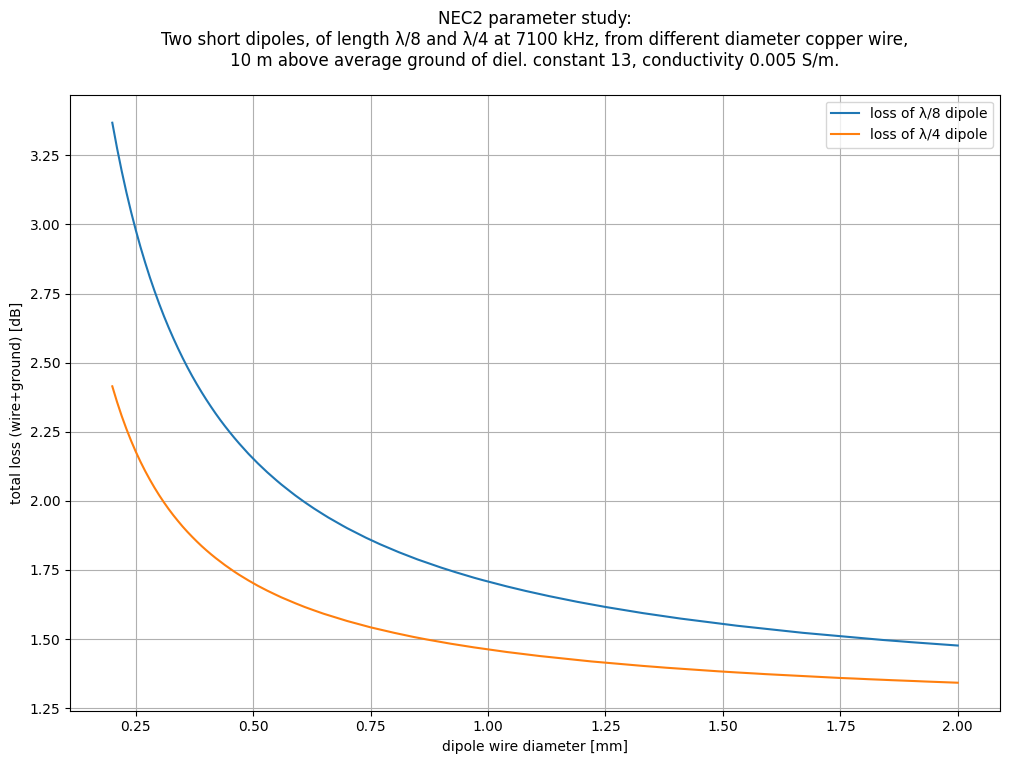

In [30]:
total_loss_per_wire_diameter = pd.DataFrame(
    {
        "loss of λ/8 dipole": [dBloss_from_efficiency(nr.total_efficiency.efficiency) for nr in dia_dipoles_λ_8],
        "loss of λ/4 dipole": [dBloss_from_efficiency(nr.total_efficiency.efficiency) for nr in dia_dipoles_λ_4],
    },
    index = [wd*1e3 for wd in wire_diameters]
)

title = f"NEC2 parameter study:\nTwo short dipoles, of length λ/8 and λ/4 at {f*1e-3:.0f} kHz, "\
    f"from different diameter copper wire,\n{height} m above " \
    "average ground of diel. constant 13, conductivity 0.005 S/m.\n"

axs = total_loss_per_wire_diameter.plot.line(
    figsize=(12,8),
    grid=True,
    title=title,
    xlabel="dipole wire diameter [mm]",
    ylabel="total loss (wire+ground) [dB]"
)
plt.show()

In [31]:
print(title)
print("\nEach wire diameter is followed by two numbers:\n"
      "The total loss (wire + ground) of a dipole of length λ/4 and that of a dipole of length λ/8."
)

print()
for i in range(0, len(total_loss_per_wire_diameter),10):
    r = total_loss_per_wire_diameter.iloc[i]
    print(
        f"{r.name:.1f} mm: "
        f"{r['loss of λ/4 dipole'].real:.2f} dB, "
        f"{r['loss of λ/8 dipole'].real:.2f} dB"
    )

NEC2 parameter study:
Two short dipoles, of length λ/8 and λ/4 at 7100 kHz, from different diameter copper wire,
10 m above average ground of diel. constant 13, conductivity 0.005 S/m.


Each wire diameter is followed by two numbers:
The total loss (wire + ground) of a dipole of length λ/4 and that of a dipole of length λ/8.

0.2 mm: 2.41 dB, 3.37 dB
0.3 mm: 2.02 dB, 2.71 dB
0.4 mm: 1.82 dB, 2.37 dB
0.5 mm: 1.70 dB, 2.15 dB
0.6 mm: 1.62 dB, 2.01 dB
0.7 mm: 1.57 dB, 1.90 dB
0.8 mm: 1.52 dB, 1.82 dB
0.9 mm: 1.49 dB, 1.76 dB
1.0 mm: 1.46 dB, 1.71 dB
1.1 mm: 1.44 dB, 1.67 dB
1.2 mm: 1.42 dB, 1.63 dB
1.3 mm: 1.41 dB, 1.60 dB
1.4 mm: 1.39 dB, 1.58 dB
1.5 mm: 1.38 dB, 1.55 dB
1.6 mm: 1.37 dB, 1.53 dB
1.7 mm: 1.36 dB, 1.52 dB
1.8 mm: 1.36 dB, 1.50 dB
1.9 mm: 1.35 dB, 1.49 dB
2.0 mm: 1.34 dB, 1.48 dB


In [32]:
# To help garbage collection:

dia_dipoles_λ_4 = None
dia_dipoles_λ_8 = None

### Discussion of result

Widening the wire diameter from our standard 1 mm to 2 mm reduces loss only slightly:
About 0.1 dB for the reasonable dipole and slightly above 0.2 dB for the dipole of desperation.
So most ops will not deem it worth the expense to quadruple the amount of copper needed.

Over the average ground modeled here, one needs to decrease wire diameter
to a flimsy 0.25 mm before wire losses finally catch up with ground losses
for the dipole of desperation. Even thinner wire would be needed for the reasonable dipole
for the same feat.

This rather supports the old lore that antenna experiments
can be done with whatever wire happens to be at hand.

On the other hand, buying expensive wire can buy resistance against ultraviolet light
and weather in general, long-term length stability, and - not to be forgotten! - bird safety.
From a purely electrical point of view, most material from the hardware store or
whatever may be available in the proverbial junk box is probably just fine.

The obvious advice from this (less than helpful for most of us):
Instead of investing in copper, move to a better ground.

## The inverted-U antenna

The "hwg" concept is summarized as "hang what fits". Frequently,
a straight line is not optimal to use the available space.

E.g., if what you've got is a balcony, you may have limited space horizontally,
so your dipole length is restricted. But you may have a bit of leeway downwards,
before wires start to touch your neighbor's balcony or windows.

This leads to the "inverted U" or "n" or "Π" antenna
(in German, could also be called "Hängeohrenantenne"):
It starts with a plain straight horizontal dipole,
but then, a vertical wire is attached to each dipole end
and simply allowed to dangle down.

To see what that does for us, we use an extremely short dipole
with a horizontal stretch of λ/10 as a start. When we add longer
and longer vertical arms, what happens?

### Impedance of an inverted-U example

In [33]:
def generate_inv_u_input(l: float, down_length: float, f: float,
                         height: float = 10.0, wire_radius= 5e-4, ideal_wire = False,
                         ground_type = "average", n_h=17, n_v=9) -> str:
    """Generate the input nec2++ expects.
    
    f in Hz, l in m.
    """
    λ = 3e8 / f

    input = ("CM Simple dipole antennas for various parameter studies.\n"
        # end of comment:
        "CE Here is one of many examples:\n"

        # tag number, number of segments, x,y,z of endpoint, x,y,z of other endpoint, wire radius
        f"GW 1 {2*n_h+1}  {-l/2:.3f} .0 {height:.2f}   {l/2:.3f} .0 {height:.2f}  {wire_radius:.3e}\n"

        + (
            f"GW 2 {n_v} {-l/2:.3f} .0 {height:.2f} {-l/2:.3f} .0 {height-down_length:.2f}   {wire_radius:.3e}\n" \
            f"GW 3 {n_v} {l/2:.3f} .0 {height:.2f} {l/2:.3f} .0 {height-down_length:.2f}   {wire_radius:.3e}\n" if down_length > 0 else ""
        ) +

        # end of geometry
        "GE\n" + \
        # Ground: 2 0 0 0 finite ground with no ground-screen, dielectric constant, conductivity in mhos / m
        ("GN 1\n" if ground_type == "ideal" else f"GN 2 0 0 0 {GROUNDS[ground_type][0]} {GROUNDS[ground_type][1]}\n") + \
        ("" if ideal_wire else "LD 5 1 0 0 58.1e6\n") + \

        # Excitation: 0 Voltage source, 1 tag number and segment number where the excitation happens,
        # the following 0 is for general sanity, the following one or two floats give the (real or complex) voltage.
        f"EX 0 1 {n_h+1} 0 1.0\n"
        # Frequencies: 0: linear stepping, 1: number of frequencies stepped through, 0, 0,
        # then starting frequency in MHz and stepping increment.
        f"FR 0 1 0 0 {f*1e-6:.6f} 0.00\n"
        # Actually run the simulation:
        "RP 0 37 145 1003 0.0 0.0 2.5 2.5 0.0 0.0\n"
        "EN\n" )
    return input

print(generate_inv_u_input(l=20, down_length=1, f=7e6))

CM Simple dipole antennas for various parameter studies.
CE Here is one of many examples:
GW 1 35  -10.000 .0 10.00   10.000 .0 10.00  5.000e-04
GW 2 9 -10.000 .0 10.00 -10.000 .0 9.00   5.000e-04
GW 3 9 10.000 .0 10.00 10.000 .0 9.00   5.000e-04
GE
GN 2 0 0 0 13 0.005
LD 5 1 0 0 58.1e6
EX 0 1 18 0 1.0
FR 0 1 0 0 7.000000 0.00
RP 0 37 145 1003 0.0 0.0 2.5 2.5 0.0 0.0
EN



In [34]:
down_lengths = [0.1 * i for i in range(0, 96)]

start = datetime.datetime.now()
inv_u_sim_results = [
    run_nec2pp(generate_inv_u_input(l=0.1*λ, down_length=down_length, f=f, ideal_wire=False, ground_type="average"))
    for down_length in down_lengths
]
duration = (datetime.datetime.now() - start).total_seconds()
num_of_simulations = len(down_lengths)
print(f"That took {duration:.2f} s for {num_of_simulations} simulations "
      f"at {duration * 1e3 / num_of_simulations:.2f} ms / simulation on average.")

That took 19.22 s for 96 simulations at 200.21 ms / simulation on average.


In [35]:

def tuner_loss_at_q(input_impedance: complex, q: float=200, z0:float =50) -> float:
    from math import log
    # I haven't gotten the time right now to do the math, so I throw this at my computer:
    def xl_to_r_minus_z0(xl: float)-> float:
        zl = xl * (1j + 1/q)
        conductivity = 1 / (input_impedance + zl)
        return 1 / conductivity.real - z0
    if 0 < input_impedance.imag or z0 <= input_impedance.real:
        return None
    solver_result = root_scalar(xl_to_r_minus_z0, x0=-input_impedance.imag)
    if not solver_result.converged:
        return None
    else:
        xl = solver_result.root
        if xl > 0 and -input_impedance.imag < xl:
            loss_r = xl/q
            antenna_r = input_impedance.real
            loss_coefficient = (antenna_r+loss_r) / antenna_r
            return 10*log(loss_coefficient)/log(10)
        else:
            return None
        

inv_u = pd.DataFrame(
    {
        "impedance": [complex(sr.input_and_impedance.impedance.real, sr.input_and_impedance.impedance.imag) for sr in inv_u_sim_results],
        "real part impedance": [sr.input_and_impedance.impedance.real for sr in inv_u_sim_results],
        "imag part impedance": [sr.input_and_impedance.impedance.imag for sr in inv_u_sim_results],
        # "efficiency in %": [sr.total_efficiency.efficiency * 100 for sr in inv_u_sim_results],
        "loss in dB": [dBloss_from_efficiency(sr.total_efficiency.efficiency) for sr in inv_u_sim_results],
        "tuner loss in dB": [tuner_loss_at_q(sr.input_and_impedance.impedance) for sr in inv_u_sim_results]
    },
    index = down_lengths
)

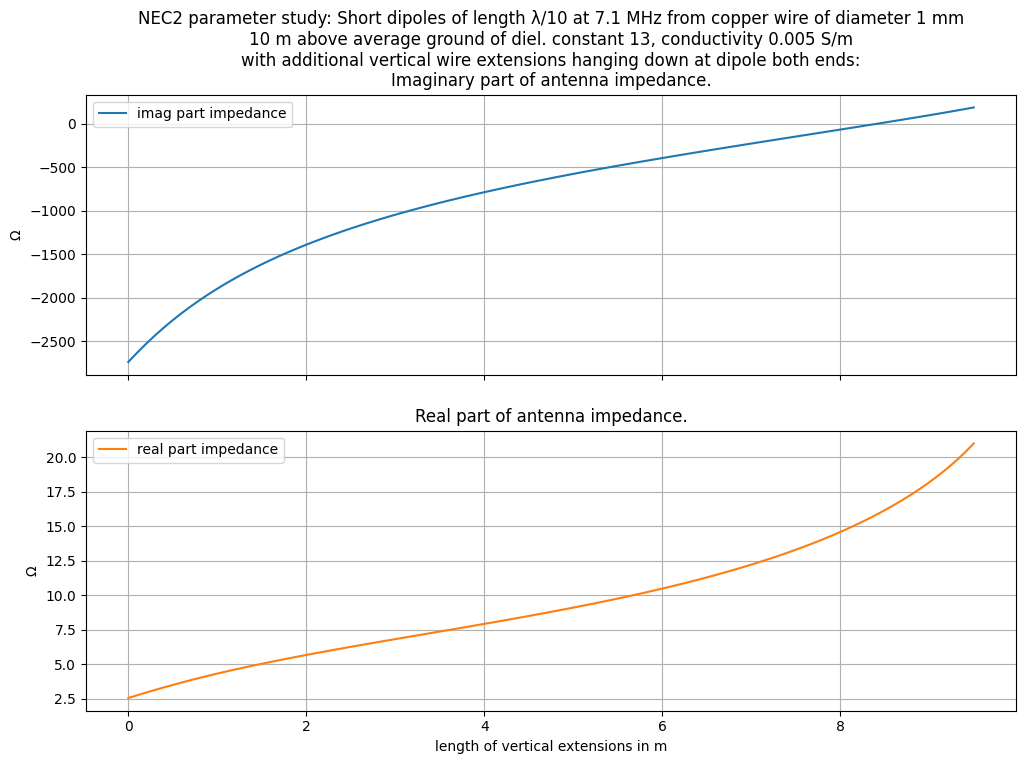

In [36]:
title_head = f"NEC2 parameter study: Short dipoles of length λ/10 at {f/1e6} MHz "\
    "from copper wire of diameter 1 mm\n" \
    f"{height} m above average ground of diel. constant 13, conductivity 0.005 S/m\n" \
    "with additional vertical wire extensions hanging down at dipole both ends"

titles = [title_head + ":\nImaginary part of antenna impedance.", "Real part of antenna impedance."]

axs = inv_u[["imag part impedance", "real part impedance"]].plot.line(
    figsize=(12,8),
    subplots=True,
    grid=True,
    title=titles,
    xlabel="length of vertical extensions in m",
    ylabel="Ω"
)
plt.show()

In [37]:
print(title_head)
print(
    "\nEach line has three numbers: Length of the two dangling vertical extensions dangling down from the dipole ends,\n"
    "followed by the real part, then the imaginary part of the resulting antenna impedance, both in Ω.\n\n"
    "Additional data points are given in the 8-8.5 m length interval.\n"
)

for i in sorted([i for i in range(0,96,5)] + [i for i in range(81,85)]):
    r = inv_u.iloc[i]
    print(
        # f"{r.index[i]} m: "
        f"{r.name:3.1f} m: " \
        f"{r['real part impedance'].real:5.1f} {r['imag part impedance'].real:8.1f}"
    )

NEC2 parameter study: Short dipoles of length λ/10 at 7.1 MHz from copper wire of diameter 1 mm
10 m above average ground of diel. constant 13, conductivity 0.005 S/m
with additional vertical wire extensions hanging down at dipole both ends

Each line has three numbers: Length of the two dangling vertical extensions dangling down from the dipole ends,
followed by the real part, then the imaginary part of the resulting antenna impedance, both in Ω.

Additional data points are given in the 8-8.5 m length interval.

0.0 m:   2.5  -2739.0
0.5 m:   3.5  -2258.1
1.0 m:   4.3  -1896.7
1.5 m:   5.0  -1616.4
2.0 m:   5.7  -1391.4
2.5 m:   6.3  -1205.3
3.0 m:   6.8  -1047.3
3.5 m:   7.4   -910.1
4.0 m:   7.9   -788.5
4.5 m:   8.5   -678.8
5.0 m:   9.1   -578.2
5.5 m:   9.8   -484.6
6.0 m:  10.5   -396.2
6.5 m:  11.3   -311.6
7.0 m:  12.2   -229.7
7.5 m:  13.3   -149.2
8.0 m:  14.6    -69.1
8.1 m:  14.9    -53.0
8.2 m:  15.2    -36.8
8.3 m:  15.5    -20.6
8.4 m:  15.8     -4.3
8.5 m:  16.2     12

In [38]:
inv_u_sim_results = None

#### Discussion of results

The real part, i.e., the radiation resistance, becomes higher. So we need less current to transmit
the same power. For example, radiation resistance triples when some 3-4 m dangling wires are added at each end. 3-4 m is the height of one story in a typical building.

At the same time, the imaginary part becomes lower. One story reduces the imaginary part to about
a third of the original value. So the voltages required to force the current
into the antenna becomes lower correspondingly. 

So we can already see that the inverted U antenna will be easier to tune,
even with only a moderate length of dangling ends.

The horizontal part of the antenna sits at a height of 10 m above ground.
We push the analysis to an extreme with
dangling wires of up to 9.5 m length, so the ends hoover just 50 cm above ground.

At roughly 8.43 m dangling wires' length, the impedance becomes purely real with no imaginary part.
At that length, we have resonance. The total length of wire in this antenna is then roughly λ/2.

### Losses of the inverted-U antenna example

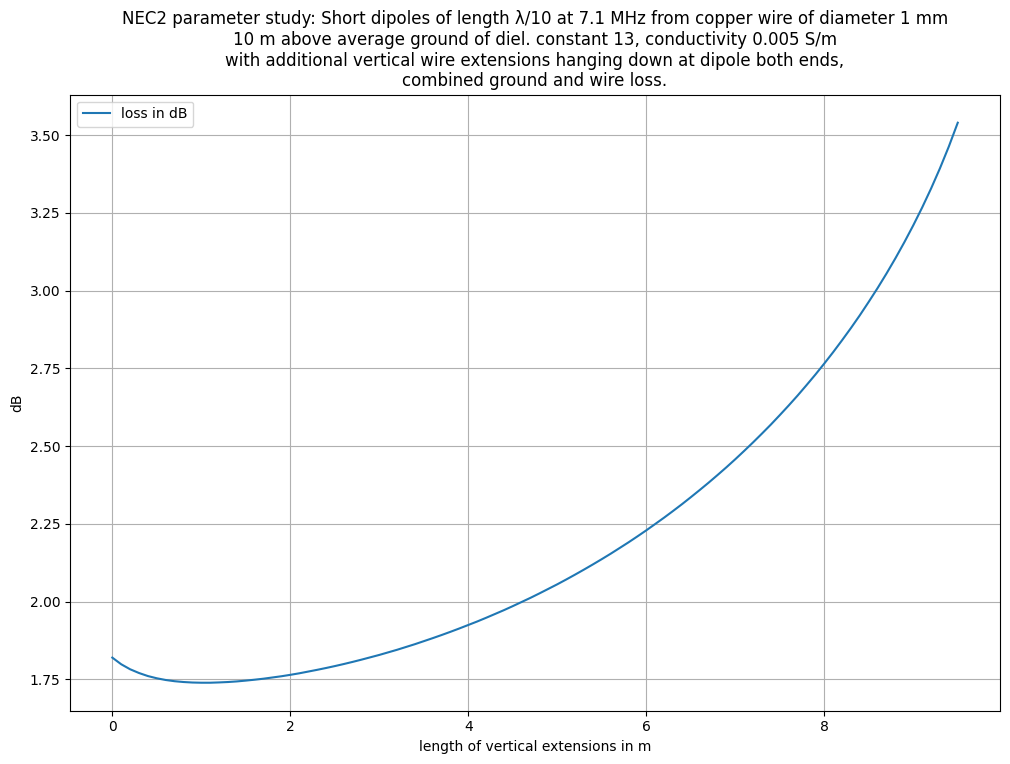

In [39]:
title = f"NEC2 parameter study: Short dipoles of length λ/10 at {f/1e6} MHz "\
    "from copper wire of diameter 1 mm\n" \
    f"{height} m above average ground of diel. constant 13, conductivity 0.005 S/m\n" \
    "with additional vertical wire extensions hanging down at dipole both ends,\n" \
    "combined ground and wire loss."

axs = inv_u[["loss in dB"]].plot.line(
    figsize=(12,8),
    # subplots=True,
    grid=True,
    title=title,
    xlabel="length of vertical extensions in m",
    ylabel="dB"
)
plt.show()

In [40]:
print(title, "\n")
for i in [i for i in range(0,96,5)]:
    r = inv_u.iloc[i]
    print(
        # f"{r.index[i]} m: "
        f"{r.name:3.1f} m: " \
        f"{r['loss in dB'].real:5.1f} dB"
    )

NEC2 parameter study: Short dipoles of length λ/10 at 7.1 MHz from copper wire of diameter 1 mm
10 m above average ground of diel. constant 13, conductivity 0.005 S/m
with additional vertical wire extensions hanging down at dipole both ends,
combined ground and wire loss. 

0.0 m:   1.8 dB
0.5 m:   1.8 dB
1.0 m:   1.7 dB
1.5 m:   1.7 dB
2.0 m:   1.8 dB
2.5 m:   1.8 dB
3.0 m:   1.8 dB
3.5 m:   1.9 dB
4.0 m:   1.9 dB
4.5 m:   2.0 dB
5.0 m:   2.1 dB
5.5 m:   2.1 dB
6.0 m:   2.2 dB
6.5 m:   2.3 dB
7.0 m:   2.5 dB
7.5 m:   2.6 dB
8.0 m:   2.8 dB
8.5 m:   3.0 dB
9.0 m:   3.2 dB
9.5 m:   3.5 dB


#### Discussion of results

The losses briefly decrease before picking up again, first slowly, then more pronouncedly.

In an experiment, instead of copper wire, ideal wire was used (not shown).
This lead to very similar results, the loss at 9.5 m decreased from 3.5 dB to 3.3 dB.

So the losses we are seeing here are almost entirely ground losses.
Apparently, ground losses increase as the dangling wires bring the electric field closer to ground.

### Tuner losses, and combined losses

We now assume an tuner (with serial L and parallel C as before)
where the L has a "pretty good" quality factor Q of 200.
With increased length of the dangling wires, tuner losses decrease
while ground losses increase.

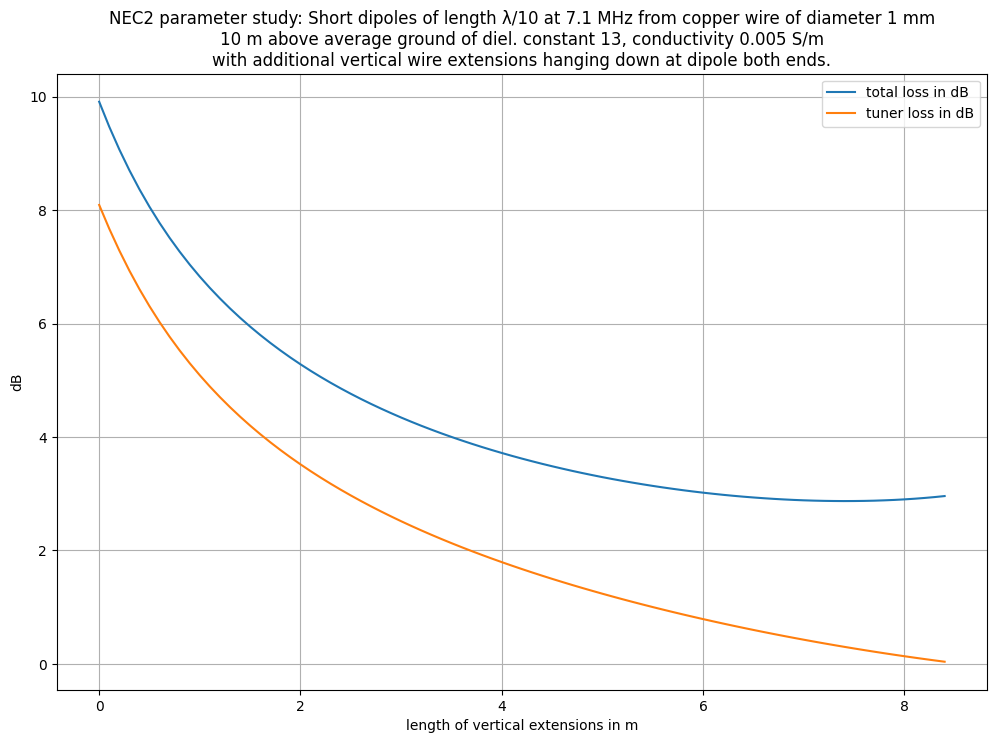

In [41]:
title = f"NEC2 parameter study: Short dipoles of length λ/10 at {f/1e6} MHz "\
    "from copper wire of diameter 1 mm\n" \
    f"{height} m above average ground of diel. constant 13, conductivity 0.005 S/m\n" \
    "with additional vertical wire extensions hanging down at dipole both ends."

inv_u["total loss in dB"] = inv_u["tuner loss in dB"] + inv_u["loss in dB"]

axs = inv_u[["total loss in dB", "tuner loss in dB"]].plot.line(
    figsize=(12,8),
    subplots=False,
    grid=True,
    title=title,
    xlabel="length of vertical extensions in m",
    ylabel="dB"
)
plt.show()

In [42]:
print(
    title,
    "\n\nEach line gives the length of the dangling ends, the tuner loss, and the total loss.\n"
    "The range 7-8 m has been boosted.\n"
)
for i in sorted([i for i in range(0,96,5)] + [i for i in range(70,80)]):
    r = inv_u.iloc[i]
    if not isnan(r['total loss in dB'].real):
        print(
            # f"{r.index[i]} m: "
            f"{r.name:3.1f} m: " \
            f"{r['tuner loss in dB'].real:7.2f} dB"
            f"{r['total loss in dB'].real:7.2f} dB"
        )

NEC2 parameter study: Short dipoles of length λ/10 at 7.1 MHz from copper wire of diameter 1 mm
10 m above average ground of diel. constant 13, conductivity 0.005 S/m
with additional vertical wire extensions hanging down at dipole both ends. 

Each line gives the length of the dangling ends, the tuner loss, and the total loss.
The range 7-8 m has been boosted.

0.0 m:    8.09 dB   9.91 dB
0.5 m:    6.31 dB   8.06 dB
1.0 m:    5.09 dB   6.83 dB
1.5 m:    4.20 dB   5.95 dB
2.0 m:    3.52 dB   5.28 dB
2.5 m:    2.97 dB   4.76 dB
3.0 m:    2.52 dB   4.34 dB
3.5 m:    2.13 dB   4.00 dB
4.0 m:    1.79 dB   3.72 dB
4.5 m:    1.50 dB   3.48 dB
5.0 m:    1.24 dB   3.29 dB
5.5 m:    1.00 dB   3.14 dB
6.0 m:    0.79 dB   3.02 dB
6.5 m:    0.60 dB   2.93 dB
7.0 m:    0.43 dB   2.88 dB
7.0 m:    0.43 dB   2.88 dB
7.1 m:    0.39 dB   2.88 dB
7.2 m:    0.36 dB   2.87 dB
7.3 m:    0.33 dB   2.87 dB
7.4 m:    0.30 dB   2.87 dB
7.5 m:    0.27 dB   2.87 dB
7.5 m:    0.27 dB   2.87 dB
7.6 m:    0.24 dB   

#### Discussion of results

As was expected, the tuner losses become lower as the antenna approaches resonance.

The combined ground, wire, and tuner losses reach a bearable 4 dB at single story height
and a low in the 2.9 dB area once the ends can dangle past two stories.

How much worse is this, compared with a full size half-wave straight dipole?
The latter needs no tuner and, over the same average ground and with the same copper wire,
has losses of 1.3 dB. So for the price of additional loss of 1.6 dB
(1.6 dB loss translate to 69 % efficiency), we can do with a fifth
of the horizontal space required by a full size dipole.

In [43]:
# Let us see what 1.6dB loss means:
10**-0.16

0.6918309709189365

This ends this parameter study collection. Some general remarks follow.

## Limitations

Known limitations of this material include:

### Other capacitive loading

We use dangling ends for our inverted-U antenna. That form of wire is not mandatory.
Instead of dangling them down, it is worth some future exploration what happens if those ends
are layed out in a spiral, some zig-zag pattern, or whatever.

The dangling wires could also be replace by vertical surfaces of sheet metal, so
each end of the horizontal dipole is attached to one such surface.

Wire meash could also be used, chicken wire or similar.
It offers a cheaper alternative to sheet metal
that is pretty much equally good electrically.
I expect fairly moderate amounts of such surface capacitive loading
can sometimes dramatically reduce antenna and tuner losses.
This has not been examined.

### Effects of buildings

Space is often limited by buildings. Buildings can affect antennas,
usually introducing additional losses.
This very much depends on the building material used:
Wooden walls next to an antenna wire will probably cause little harm,
but concrete+steel may be a different matter.

No attempt has been made to investigate any of that.

### Radiation pattern

Even with straight dipoles, funny things can happen to the radiation pattern.
This is more a concern for long antennas, as opposed to the short ones discussed here.

The interested reader is invited to open any book that has the pertinent antenna theory,
and find the page where it has the radiation diagram of an antenna that is several λ long.
Alternatively, run an antenna simulation on a center-fed antenna that is, say, 3½λ long,
and study the radiation pattern.

More pertinent to the hwg concept, height is also important.
Sometimes, antenna height is given by circumstances and
cannot be influenced much. Generally, insufficient height causes the antenna to favor steep radiation angles.
Such antennas are sometimes affectionally called "sky warmers" or "cloud heaters".
Such antennas may be good for NVIS, but are bad for DX.

A short dipole inherently looses 0.4 dB compared with a half-wave dipole, because its radiation pattern is broader
(German source: Alois Krische DJ0TR (sk): "Rothammels Antennenbuch", 13. Auflage, Seite 110).
This broadness is also an advantage, as the hwg concept per definition means to hang antennas where they fit;
it is sheer luck if that makes them point into a direction most wanted, and they usually cannot be rotated.

### Other small antennas

This document sticks to center-fed dipole antennas. Many other antenna types are not being discussed,
which includes magnetic loops and all types of non-symmetric antennas.

The examinations done here could be extended to vertical dipoles, but they are not covered here, either.

### Disturbances and noise

Antennas pick up wanted signals and unwanted noise. The latter roams buildings' electricity wires. An inherent
danger in the hwg-concept is that one may run the antenna wire close to the house and its wiring. Such an antenna
may be prone to pick up noise on receive. It may be worth, even in crowded
environments, to think about *two* antennas: A small active antenna somewhat further away from the electric noise for
reception, and a hwg antenna for transmit.

On transmit, hwg antennas can induce unwanted HF energy into a house's wiring.

## License

If you want to use the Python code that is contained in this document, here is the license for that:

> Copyright 2024 and 2025 by Andreas Krüger, DJ3EI
> 
> Permission is hereby granted, free of charge, to any person obtaining
> a copy of this software and associated documentation files (the
> “Software”), to deal in the Software without restriction, including
> without limitation the rights to use, copy, modify, merge, publish,
> distribute, sublicense, and/or sell copies of the Software, and to
> permit persons to whom the Software is furnished to do so, subject to
> the following conditions:
> 
> The above copyright notice and this permission notice shall be
> included in all copies or substantial portions of the Software.
>
> THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND,
> EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
> MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
> NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
> LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
> OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION
> WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

The other material in this document, all that's not Python code,
is also Copyright 2024 and 2025 by Andreas Krüger, DJ3EI.  That material
is licensed to you under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/).

## To reproduce

You need a recent Python. Original development happened with Python 3.11
(3.11.2, if you need to know, but you probably don't). Python 3.12 and 3.13 should work as well.

You need to install my [antenna simulation driver](https://pypi.org/project/antenna-simulation-driver/) Python software. This notebook was originally developed with version 0.1.3.

That driver in turn wants a working installation of `nec2++`. This is yet another yak to shave,
see the next section.

To run this Jupyter Notebook, you also need some additional "usual suspects" software,
preferably installed in a `venv` [virtual environment](https://docs.python.org/3/library/venv.html):

```
notebook
pandas
matplotlib
scipy
```

When all is well, `jupyter notebook` should open a notebook environment in your browser
and you should be able to open and rerun this notebook
(with Kernel / Restart Kernel and Run all cells).

Expect that to take a while, as quite a few `nec2++` runs are fired. (On my 2015
dual core laptop, the entire notebook takes some 4 to 5 minutes.)

### NEC2 implementation used

This document uses `nec2++` from the `necpp` project
at [https://github.com/tmolteno/necpp.git](https://github.com/tmolteno/necpp.git).

The Python software from [https://github.com/tmolteno/python-necpp.git](https://github.com/tmolteno/python-necpp.git) didn't work for me, so I wrote my own driver, for which this document is also some sort of test bed. To function, the driver needs the `nec2++` functionality of commit `ba8ff201`, which writes results to `stdout` if the output file name is `-`.

If you want to play with this before my pertinent [pull request](https://github.com/tmolteno/necpp/pull/82) has been accepted into `necpp`, you may need to compile [my fork](https://github.com/aknrdureegaesr/necpp). (Alternatively,
you could rig up some script with an earlier version of `nec2++`. Your script needs to manipulate the `-o` switch to write into some temp file, and, after `nec2++` has completed, write out the temp file content to stdout. If this notebook you're reading finds such a script when calling `nec2++`, things should work.)

### Precise Python versions used

For the record and possibly for the benefit of those who run into weird problems,
here are the precise versions of all Python packages I originally used to render this notebook:

```
antenna_simulation_driver==0.1.3
anyio==4.8.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
async-lru==2.0.4
attrs==24.3.0
babel==2.16.0
beautifulsoup4==4.12.3
bleach==6.2.0
certifi==2024.12.14
cffi==1.17.1
charset-normalizer==3.4.1
cloudpickle==3.1.1
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.12
decorator==5.1.1
defusedxml==0.7.1
doit==0.36.0
executing==2.1.0
fastjsonschema==2.21.1
fonttools==4.55.3
fqdn==1.5.1
h11==0.14.0
httpcore==1.0.7
httpx==0.28.1
idna==3.10
importlib_metadata==8.5.0
ipykernel==6.29.5
ipython==8.31.0
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.5
json5==0.10.0
jsonpointer==3.0.0
jsonschema==4.23.0
jsonschema-specifications==2024.10.1
jupyter-events==0.11.0
jupyter-lsp==2.2.5
jupyter_client==8.6.3
jupyter_core==5.7.2
jupyter_server==2.15.0
jupyter_server_terminals==0.5.3
jupyterlab==4.3.4
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.3
kiwisolver==1.4.8
MarkupSafe==3.0.2
matplotlib==3.10.0
matplotlib-inline==0.1.7
mistune==3.1.0
nbclient==0.10.2
nbconvert==7.16.5
nbformat==5.10.4
nest-asyncio==1.6.0
notebook==7.3.2
notebook_shim==0.2.4
numpy==2.2.1
overrides==7.7.0
packaging==24.2
pandas==2.2.3
pandocfilters==1.5.1
parso==0.8.4
pexpect==4.9.0
pillow==11.1.0
platformdirs==4.3.6
prometheus_client==0.21.1
prompt_toolkit==3.0.48
psutil==6.1.1
ptyprocess==0.7.0
pure_eval==0.2.3
pycparser==2.22
Pygments==2.19.1
pyparsing==3.2.1
python-dateutil==2.9.0.post0
python-json-logger==3.2.1
pytz==2024.2
PyYAML==6.0.2
pyzmq==26.2.0
referencing==0.36.1
requests==2.32.3
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.22.3
scipy==1.15.1
Send2Trash==1.8.3
six==1.17.0
sniffio==1.3.1
soupsieve==2.6
stack-data==0.6.3
terminado==0.18.1
tinycss2==1.4.0
tornado==6.4.2
traitlets==5.14.3
types-python-dateutil==2.9.0.20241206
typing_extensions==4.12.2
tzdata==2024.2
uri-template==1.3.0
urllib3==2.3.0
wcwidth==0.2.13
webcolors==24.11.1
webencodings==0.5.1
websocket-client==1.8.0
zipp==3.21.0
```

In [44]:
datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S Z")

'2025-01-18 18:52:01 Z'